In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose   # para descomponer la serie temporal de precios en componentes de tendencia, estacionalidad y ruido.
import seaborn as sns
from matplotlib.ticker import ScalarFormatter


import sys
import os

# IMPORTANTE - asegurarse de que el path es el correcto, tiene que apuntar a la carpeta Tools (o equivalente si se le cambia el nombre, debería ser Tools)

tools_path = os.path.abspath('Tools')
# Comprobar si existe la carpeta Tools
if os.path.exists(tools_path):
    sys.path.append(tools_path)
else:
    print("The Tools directory does not exist. Please check the path.")
# importamos toolkit.py
try:
    from toolkit import procesar_datos 
    from toolkit import regresion_modelos
    from toolkit import formatear_resultados
except ImportError as e:  # Catch ImportError para ver si hay errores al importar
    print(f"ImportError: {e}. comprueba que 'process_dataset' exista en 'toolkit.py'.")

df_energy = procesar_datos('loureiro_energy.csv')
df_weather= procesar_datos('weather_aveiro_final.csv')

 **Análisis de Calidad de los Datos**: Evaluar la calidad de los datos, identificando problemas como valores faltantes, inconsistencias, errores o duplicados.

In [3]:
print("Datos LoureiroDataset.csv") 
data_energy =df_energy.copy()
data_weather= df_weather.copy()
data_energy['Time'] = pd.to_datetime(data_weather['Time'])
data_energy['Time'] = pd.to_datetime(data_weather['Time'])

# Contar duplicados
num_duplicados = data_energy.duplicated().sum()
print(f"Número de filas duplicadas data_energy: {num_duplicados}")
num_duplicados = data_weather.duplicated().sum()
print(f"Número de filas duplicada data_weathers: {num_duplicados}")


#data_energy.set_index('Time', inplace=True)
data_energy=data_energy.set_index('Time')
data_weather=data_weather.set_index('Time')

#print(data_energy.shape#
#print(data_energy.head())

pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.width', 1000)       # Aumentar el ancho máximo de la consola
print(data_energy.info())

# Crear un DataFrame para mostrar los nombres de las columnas y sus tipos
columns_info = pd.DataFrame({
    "Column Name": data_energy.columns,  # Nombres de las columnas
    "Data Type": data_energy.dtypes      # Tipos de datos
}).reset_index(drop=True)  # Restablecer el índice para una tabla limpia

# Mostrar la tabla
print(columns_info)

print("-" *140)
print("weather_aveiro_finalt.csv") 

#print(data_weather.shape)
#print(data_weather.head())
#print(data_weather.dtypes)
data_weather.info()


Datos LoureiroDataset.csv
Número de filas duplicadas data_energy: 0
Número de filas duplicada data_weathers: 0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 46608 entries, 2022-05-05 12:00:00 to 2023-09-02 23:45:00
Columns: 172 entries, Energy_Meter_1 to Energy_Meter_172
dtypes: float64(172)
memory usage: 61.5 MB
None
          Column Name Data Type
0      Energy_Meter_1   float64
1      Energy_Meter_2   float64
2      Energy_Meter_3   float64
3      Energy_Meter_4   float64
4      Energy_Meter_5   float64
..                ...       ...
167  Energy_Meter_168   float64
168  Energy_Meter_169   float64
169  Energy_Meter_170   float64
170  Energy_Meter_171   float64
171  Energy_Meter_172   float64

[172 rows x 2 columns]
--------------------------------------------------------------------------------------------------------------------------------------------
weather_aveiro_finalt.csv
<class 'pandas.core.frame.DataFrame'>
Index: 46608 entries, 2022-05-05 12:00:00 to 2023-09-02 23:4

In [4]:
# Summary statistics


#data_energy['Time'] = pd.to_datetime(data_energy['Time'])
# Mostrar las primeras 5 columnas de las primeras 5 filas
print(data_energy.iloc[:, :5].head())
#data_energy.dtypes
summary_data_energy = data_energy.describe() # primera columna la cantida de mediciones por dispositivos
summary_first_columns = summary_data_energy.iloc[:, :5]
print(summary_first_columns)

# Convertir la columna 'Time' a formato datetime (si no se ha hecho antes)
#data_energy['Time'] = pd.to_datetime(data_energy['Time'])

# Seleccionar solo las columnas numéricas
numeric_data_energy = data_energy.select_dtypes(include=['float64', 'int64'])

# Calcular el máximo de cada columna
max_values = numeric_data_energy.max()

# Calcular el máximo de los máximos
max_of_max = max_values.max()

# Calcular la media de cada columna
mean_values = numeric_data_energy.mean()

# Calcular la media de las medias
mean_of_means = mean_values.mean()

# Mostrar los resultados
print(f"El máximo de las mediciones ded consumo es: {max_of_max}")
print(f"La media de las mediciones del consumo es: {mean_of_means}")

#data_weather['Time'] = pd.to_datetime(data_weather['Time'])
#data_weather.dtypes
summary_data_weather = data_weather.describe()
print(summary_data_weather)


                     Energy_Meter_1  Energy_Meter_2  Energy_Meter_3  Energy_Meter_4  Energy_Meter_5
Time                                                                                               
2022-05-05 12:00:00           0.068             NaN           0.034           0.038           0.000
2022-05-05 12:15:00           0.070             NaN           0.044           0.062           0.006
2022-05-05 12:30:00           0.122             NaN           0.037           0.045           0.000
2022-05-05 12:45:00           0.132             NaN           0.015           0.039           0.000
2022-05-05 13:00:00           0.125             NaN           0.015           0.040           0.032
       Energy_Meter_1  Energy_Meter_2  Energy_Meter_3  Energy_Meter_4  Energy_Meter_5
count    41822.000000    41748.000000    31617.000000    40510.000000    39516.000000
mean         0.092643        0.062613        0.116356        0.045887        0.002955
std          0.104881        0.065718     

Verificar si están todo el rango de valores . contamos cuantos observaciones de fecha existen entre el minimo y el maximo y debe ser igual a la cantidad de observaciones 46608, creamos una serie de fechas basada en los parámetros que especificaste (start, end, freq). Tabién verificamos que los rangos son igiales a los de las dos dataset 


In [5]:
# Asegúrate de que 'full_date_range' esté en el mismo formato que los índices
#assert (full_date_range == data_energy.index).all(), "El rango de fechas no coincide en data_energy"
#assert (full_date_range == data_weather.index).all(), "El rango de fechas no coincide en data_weather"


Dispositivos ordenados de menor a mayor:
Energy_Meter_38      3365.0
Energy_Meter_46      6479.0
Energy_Meter_7       9938.0
Energy_Meter_93     11704.0
Energy_Meter_97     12381.0
                     ...   
Energy_Meter_125    41831.0
Energy_Meter_17     41837.0
Energy_Meter_132    41839.0
Energy_Meter_91     41840.0
Energy_Meter_140    41940.0
Name: count, Length: 171, dtype: float64


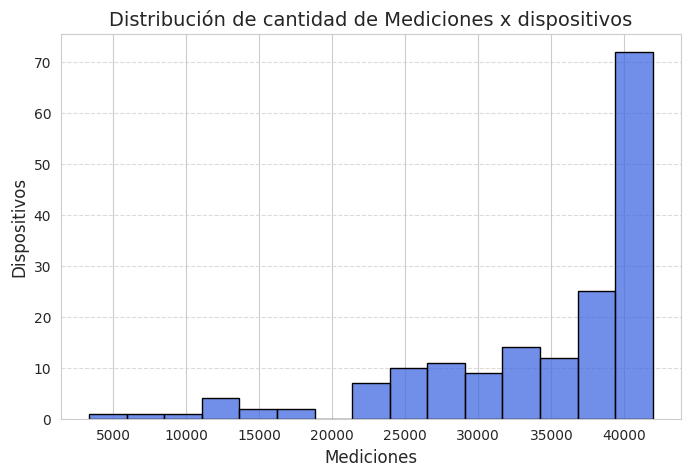

In [6]:
# Ordenar de menor a mayor
devices_sorted_asc = summary_data_energy.iloc[0, 1:].sort_values(ascending=True)
# Mostrar los resultados
print("Dispositivos ordenados de menor a mayor:")
print(devices_sorted_asc)


# Filtrar datos numéricos
data = pd.to_numeric(summary_data_energy.iloc[0, 1:], errors='coerce').dropna()

# Configuración de estilo
sns.set_style("whitegrid")

# Crear el gráfico y  
plt.figure(figsize=(8, 5))
fig1=sns.histplot(data, bins=15,  color="royalblue", edgecolor="black")

# Mejorar etiquetas y título
plt.title("Distribución de cantidad de Mediciones x dispositivos", fontsize=14)
plt.xlabel("Mediciones", fontsize=12)
plt.ylabel("Dispositivos", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Export the figure as a high-quality image


# Mostrar
plt.show()


Observamos que mas de 80 los 172 dispositivos recolectaron mas de 40.000 mediciones cerca del total(46608)

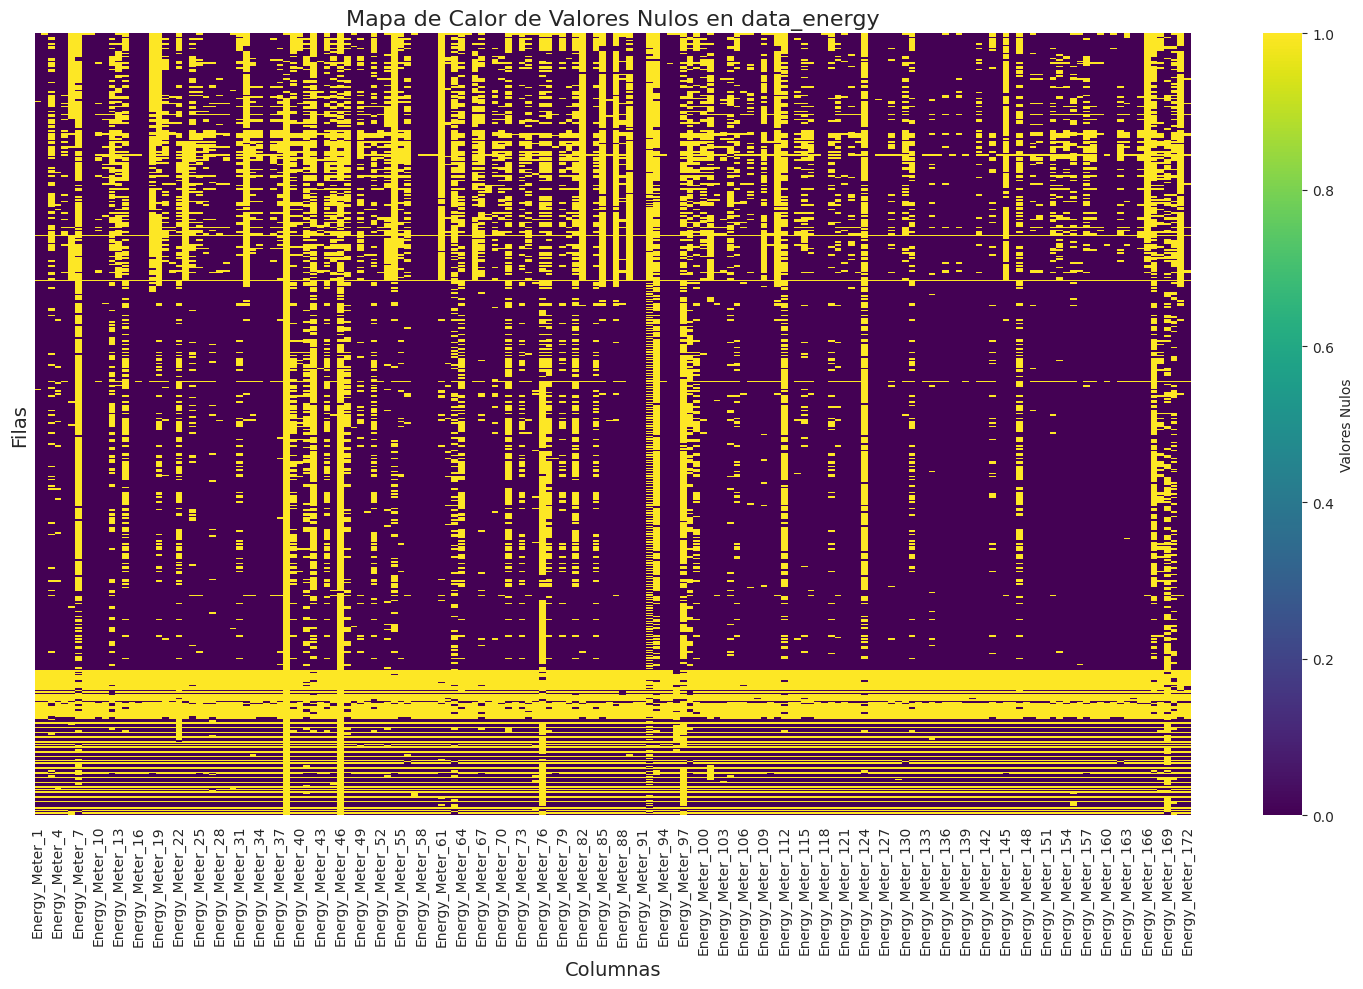

In [7]:
#Crear un mapa de calor para los valores nulos

plt.figure(figsize=(15, 10))  # Tamaño del gráfico
sns.heatmap(data_energy.isnull(), 
            cbar=True,  # Mostrar barra de colores
            cmap="viridis",  # Paleta de colores
            yticklabels=False,  # Quitar etiquetas del eje Y
            cbar_kws={"label": "Valores Nulos"})  # Etiqueta de la barra de color

# Configurar el título y ejes
plt.title("Mapa de Calor de Valores Nulos en data_energy", fontsize=16)
plt.xlabel("Columnas", fontsize=14)
plt.ylabel("Filas", fontsize=14)

# Mostrar el gráfico
plt.tight_layout()

# Guardar el gráfico como imagen PNG
plt.savefig("../Energia/img/mapa_nulos_data_energy.png", dpi=300, bbox_inches='tight')
plt.show()

Energy Meters con más del 75% de valores nulos:
['Energy_Meter_38', 'Energy_Meter_46', 'Energy_Meter_7']

Energy Meters con más de 34,956 valores cero:
['Energy_Meter_122', 'Energy_Meter_102', 'Energy_Meter_21', 'Energy_Meter_121', 'Energy_Meter_156', 'Energy_Meter_68', 'Energy_Meter_57', 'Energy_Meter_83', 'Energy_Meter_133', 'Energy_Meter_72', 'Energy_Meter_113', 'Energy_Meter_144', 'Energy_Meter_137', 'Energy_Meter_140']


/tmp/ipykernel_214890/1487360787.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


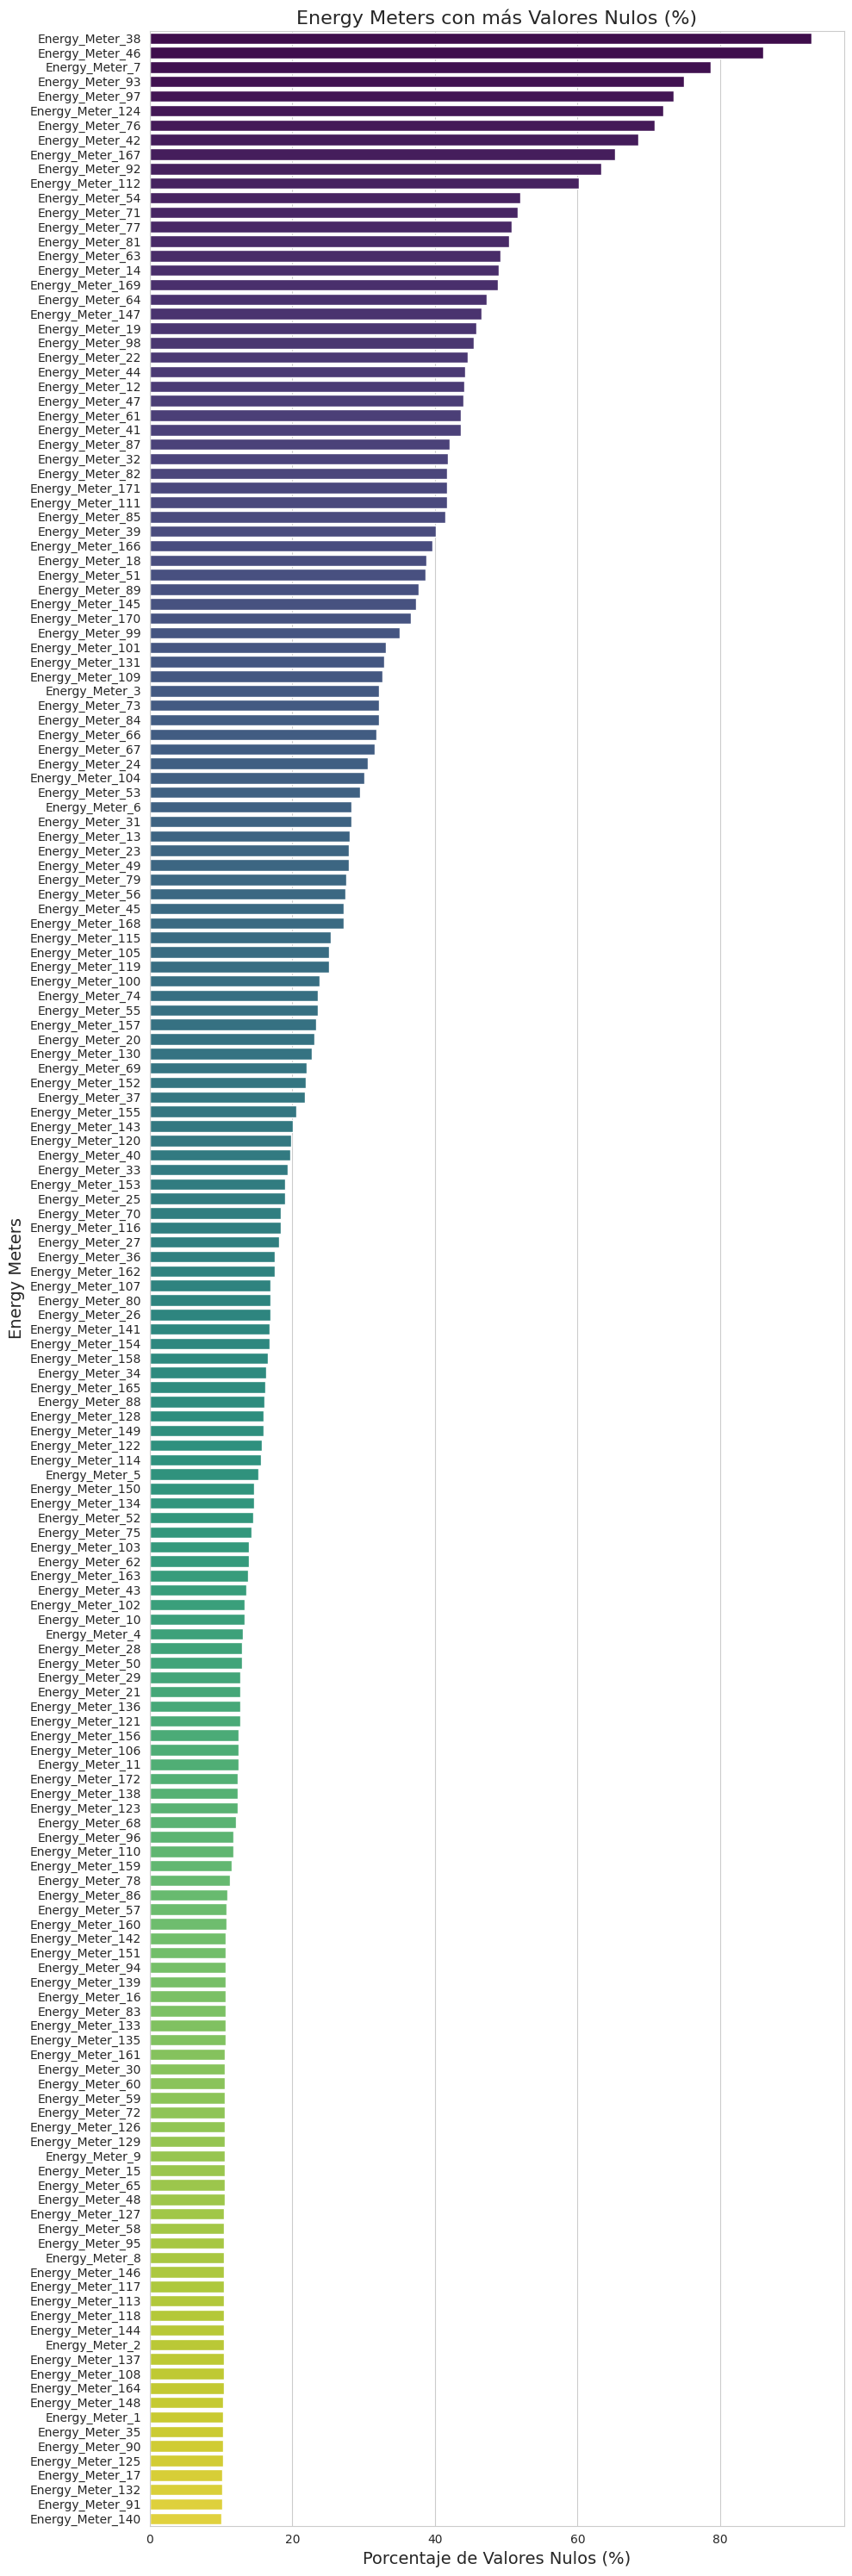

                            Column  Null_Count  Null_Percentage  Collected_Values  Zero_Counts
Energy_Meter_38    Energy_Meter_38       43243        92.780209              3365            0
Energy_Meter_46    Energy_Meter_46       40129        86.098953              6479            1
Energy_Meter_7      Energy_Meter_7       36670        78.677480              9938            0
Energy_Meter_93    Energy_Meter_93       34904        74.888431             11704            0
Energy_Meter_97    Energy_Meter_97       34227        73.435891             12381            2
...                            ...         ...              ...               ...          ...
Energy_Meter_125  Energy_Meter_125        4777        10.249313             41831          755
Energy_Meter_17    Energy_Meter_17        4771        10.236440             41837           25
Energy_Meter_132  Energy_Meter_132        4769        10.232149             41839            3
Energy_Meter_91    Energy_Meter_91        4768    

In [8]:

# Calcular valores nulos y porcentaje de valores nulos
null_counts = data_energy.isnull().sum()  # Total de valores nulos por columna
null_percentages = (null_counts / len(data_energy)) * 100  # Porcentaje de valores nulos
total_values = len(data_energy)  # Total de filas (mediciones)

# Calcular los valores recolectados (no nulos)
collected_values = total_values - null_counts  # Cantidad de valores recolectados (no nulos)

# Calcular los valores de cero
zero_counts = (data_energy == 0).sum()  # Contar cuántos valores son cero en cada columna

# Crear un DataFrame para mayor claridad
null_summary = pd.DataFrame({
    "Column": data_energy.columns,
    "Null_Count": null_counts,
    "Null_Percentage": null_percentages,
    "Collected_Values": collected_values,  # Añadir columna de valores recolectados
    "Zero_Counts": zero_counts  # Añadir columna de valores cero
}).sort_values(by="Null_Percentage", ascending=False)

# Filtrar las columnas con Null_Percentage mayor que 75
columns_null_above_75 = null_summary[null_summary["Null_Percentage"] > 75]["Column"].tolist()

# Filtrar las columnas con Zero_Counts mayor que 34,956 el 75% del total 
columns_zero_above_34956 = null_summary[null_summary["Zero_Counts"] > 34956]["Column"].tolist()

# Imprimir las listas de columnas con más del 50% de nulos y más de 34,956 ceros
print("Energy Meters con más del 75% de valores nulos:")
print(columns_null_above_75)

print("\nEnergy Meters con más de 34,956 valores cero:")
print(columns_zero_above_34956)

# Visualizar los valores nulos con barras horizontales
plt.figure(figsize=(10, 30))  # Cambiar tamaño de la figura para facilitar la visualización
sns.barplot(
    data=null_summary,  # Mostrar las primeras 20 columnas con más nulos
    y="Column", 
    x="Null_Percentage",  # Eje X será el porcentaje de valores nulos
    palette="viridis"
   
)

# Ajustes del gráfico
plt.title("Energy Meters con más Valores Nulos (%)", fontsize=16)
plt.xlabel("Porcentaje de Valores Nulos (%)", fontsize=14)
plt.ylabel("Energy Meters", fontsize=14)
plt.tight_layout()

# Asegurarse de que la figura se ajusta a los límites
plt.tight_layout()
# Mostrar el gráfico

# Guardar el gráfico como imagen PNG
plt.savefig("../Energia/img/valores_nulos_porciento.png", dpi=300, bbox_inches='tight')

# Mostrar el gráfico
plt.show()

# Mostrar la tabla de valores nulos con los nuevos totales
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas en el DataFrame
print(null_summary)


In [9]:
# Identificar columnas donde todos los valores son ceros 
columns_all_zeros_no_nulls = data_energy.columns[(data_energy == 0).all()]

# Mostrar el resultado
print("Columnas donde todos los valores son ceros :")
print(columns_all_zeros_no_nulls.tolist())


Columnas donde todos los valores son ceros :
[]


In [10]:

print(summary_data_weather.iloc[0,1:])


Avg_Rel_Humidity       46602.0
Avg_Wind_Direction     46608.0
Avg_Wind_Speed         46608.0
Max_Inst_Wind_Speed    46608.0
Inst_Temp              46603.0
Quantity_Precip        46608.0
Max_Inst_Precip        46608.0
Total_Global_Rad       46603.0
Name: count, dtype: float64


Observamos que las mediciones de los datos del tiempo estan practicamnete completas 46608. 

In [11]:
# Buscar Valores faltantes 

missing_values = data_energy.isnull().sum()
print(missing_values)
data_energy.isna().sum().sum()

Energy_Meter_1       4786
Energy_Meter_2       4860
Energy_Meter_3      14991
Energy_Meter_4       6098
Energy_Meter_5       7092
                    ...  
Energy_Meter_168    12669
Energy_Meter_169    22763
Energy_Meter_170    17071
Energy_Meter_171    19438
Energy_Meter_172     5744
Length: 172, dtype: int64


np.int64(2014280)

In [12]:
# porciento total de datos del dataset valores faltantes
nulos_dispositivos=data_energy.isna().sum().sum()/data_energy.size
nulos_dispositivos

np.float64(0.2512643802042169)

El 25 % de los datos del dataset son valores faltantes.


In [13]:
por_nulos_weather=data_weather.isna().sum().sum()
por_nulos_weather

np.int64(22)

In [14]:
Porciento_nulos_dispositivos=data_energy.isna().sum()/len(data_energy) # sumas de los nulos entre 172 dispositovo 
Porciento_nulos_dispositivos

Energy_Meter_1      0.102686
Energy_Meter_2      0.104274
Energy_Meter_3      0.321640
Energy_Meter_4      0.130836
Energy_Meter_5      0.152163
                      ...   
Energy_Meter_168    0.271820
Energy_Meter_169    0.488393
Energy_Meter_170    0.366268
Energy_Meter_171    0.417053
Energy_Meter_172    0.123241
Length: 172, dtype: float64

La distribucion de los porcientos nos indican que hay algunos dispositivos que el 60 % de los datos faltan y vemos algunos outliers y tambien 
algun dispositivo tiene el 80 porciento sin valores nos puede indicar un mal funcionamiento o un defase con en el tiempo con los otros dispositivos,
PUDIERA SER UNA TEMA A DISCUTIR CON LOS ESPECIALISTA SOBRE LA VIAVILIDAD DEL PROYECTO. Sin embargo tenemos otros dispositivos que no tienen tantos valores faltantes.

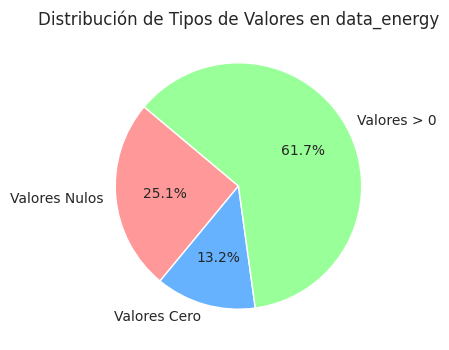

In [15]:

# Calcular el total de valores
total_values = data_energy.size

# Calcular valores nulos, ceros y mayores que cero
null_values = data_energy.isnull().sum().sum()
zero_values = (data_energy == 0).sum().sum()
greater_than_zero = total_values - null_values - zero_values

# Calcular porcentajes
percentages = [
    (null_values / total_values) * 100,  # Porcentaje de nulos
    (zero_values / total_values) * 100,  # Porcentaje de ceros
    (greater_than_zero / total_values) * 100  # Porcentaje de valores > 0
]

# Etiquetas para el gráfico
labels = ['Valores Nulos', 'Valores Cero', 'Valores > 0']

# Crear el gráfico circular
plt.figure(figsize=(4, 4))
plt.pie(
    percentages, 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=['#FF9999', '#66B2FF', '#99FF99']
)
plt.title('Distribución de Tipos de Valores en data_energy')

# Guardar el gráfico en un archivo
plt.savefig("../Energia/img/distribution_of_values.png", dpi=100, bbox_inches='tight')

# Mostrar el gráfico
plt.show()


Text(0, 0.5, 'Dispositivos')

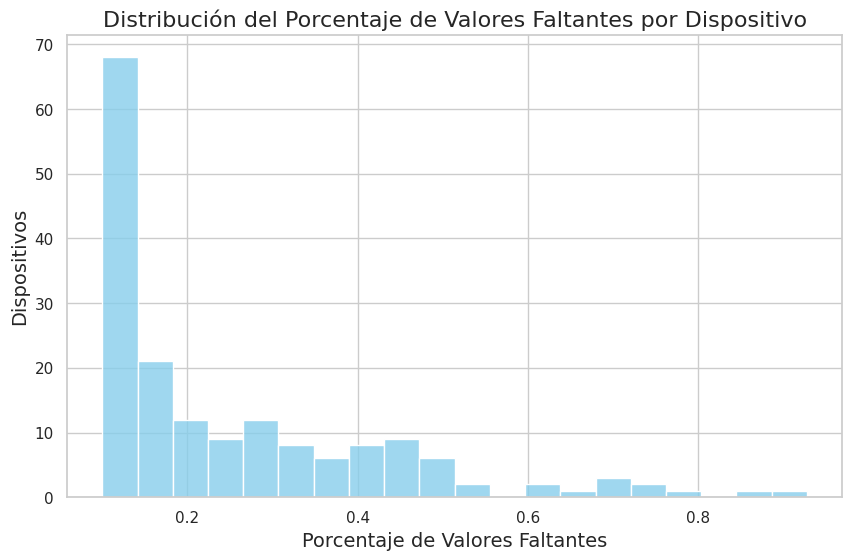

In [16]:
# Configuración de estilo
sns.set(style="whitegrid")

# Crear histograma mejorado
plt.figure(figsize=(10, 6))
sns.histplot(Porciento_nulos_dispositivos, 
             bins=20, 
             color="skyblue", 
             alpha=0.8)
# Títulos y etiquetas
plt.title("Distribución del Porcentaje de Valores Faltantes por Dispositivo", fontsize=16)
plt.xlabel("Porcentaje de Valores Faltantes", fontsize=14)
plt.ylabel("Dispositivos", fontsize=14)




La distribucion de los porcientos nos indican que hay algunos dispositivos que el 60 % de los datos faltan y vemos algunos outliers
y tambien algun dispositivo tiene el 80 porciento sin valores nos puede indicar un mal funcionamiento o un defase con en el tiempo con 
los otros dispositivos, PUDIERA SER UNA TEMA A DISCUTIR CON LOS ESPECIALISTA SOBRE LA VIAVILIDAD DEL PROYECTO. Sin embargo tenemos otros
dispositivos que no tienen tantos valores faltantes.

Energy_Meter_38
Energy_Meter_46
Energy_Meter_7


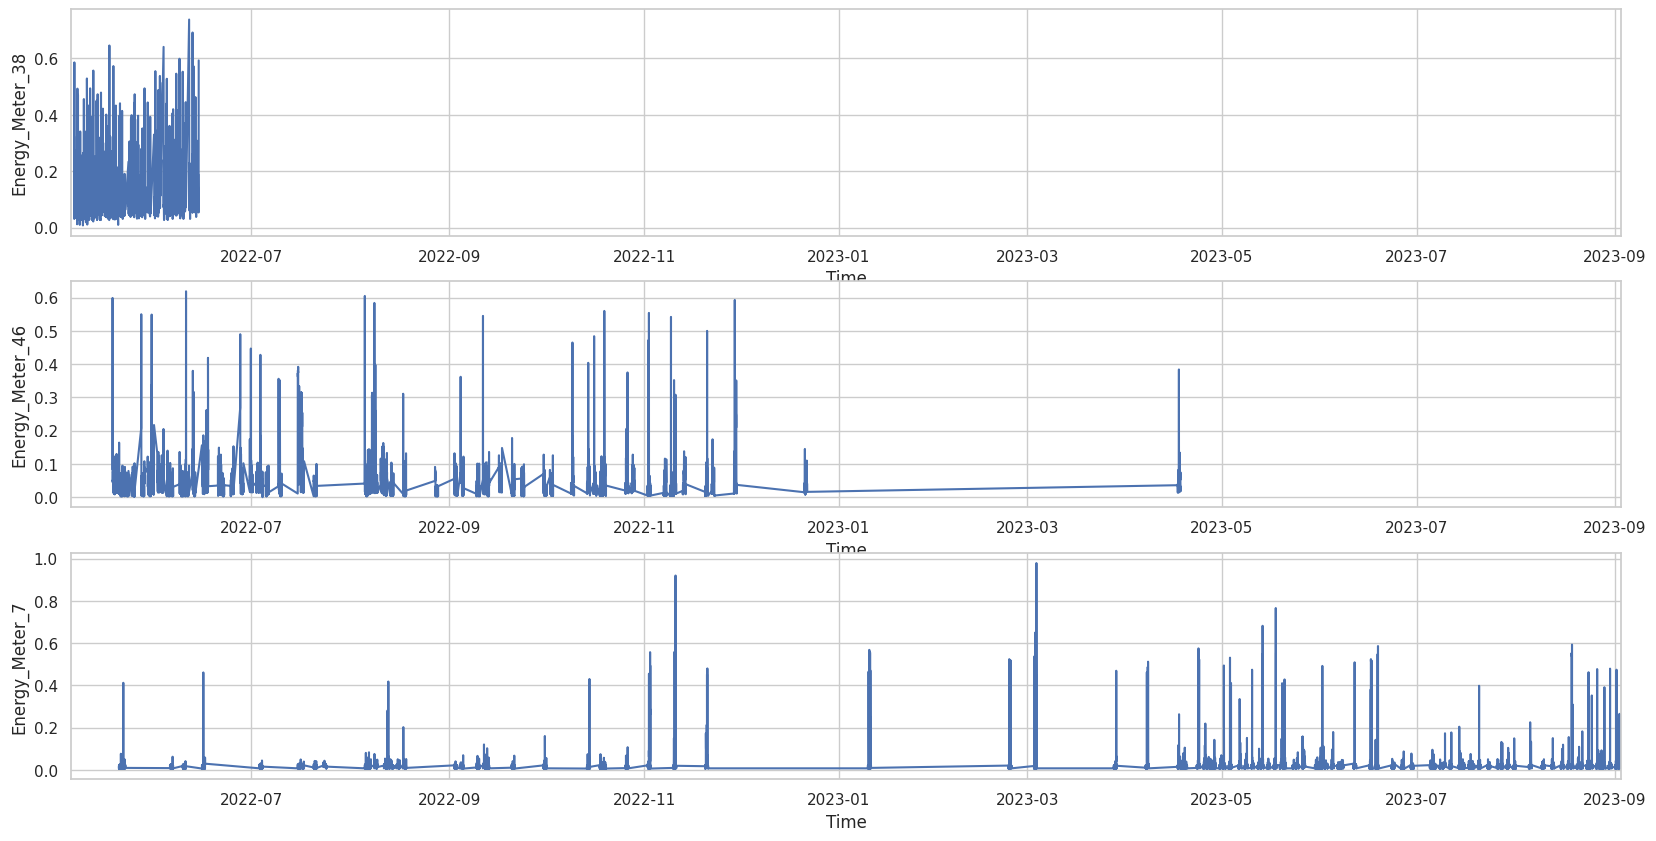

In [17]:
# Which are the devices with highest % of missing values top 3
low_value_meters = Porciento_nulos_dispositivos.sort_values(ascending=False).index[0:3]
low_value_meters
fig, ax = plt.subplots(nrows=3, figsize=(20,10))
for i, column in enumerate(low_value_meters):
    print(column)
    plot1 = sns.lineplot(data_energy[column], ax = ax[i])
    plot1.set_xlim(data_energy.index.min(), data_energy.index.max())
# Guardar el gráfico como imagen PNG
plt.savefig("../Energia/img/fig8tot3nulos.png", dpi=300, bbox_inches='tight')

Con las graficas anteriores podemosver el funcionamiento irregular de alguno dispositivos y encontramos comportamientos
interesante como el mes 6

Energy_Meter_140
Energy_Meter_91
Energy_Meter_132
Energy_Meter_17
Energy_Meter_125


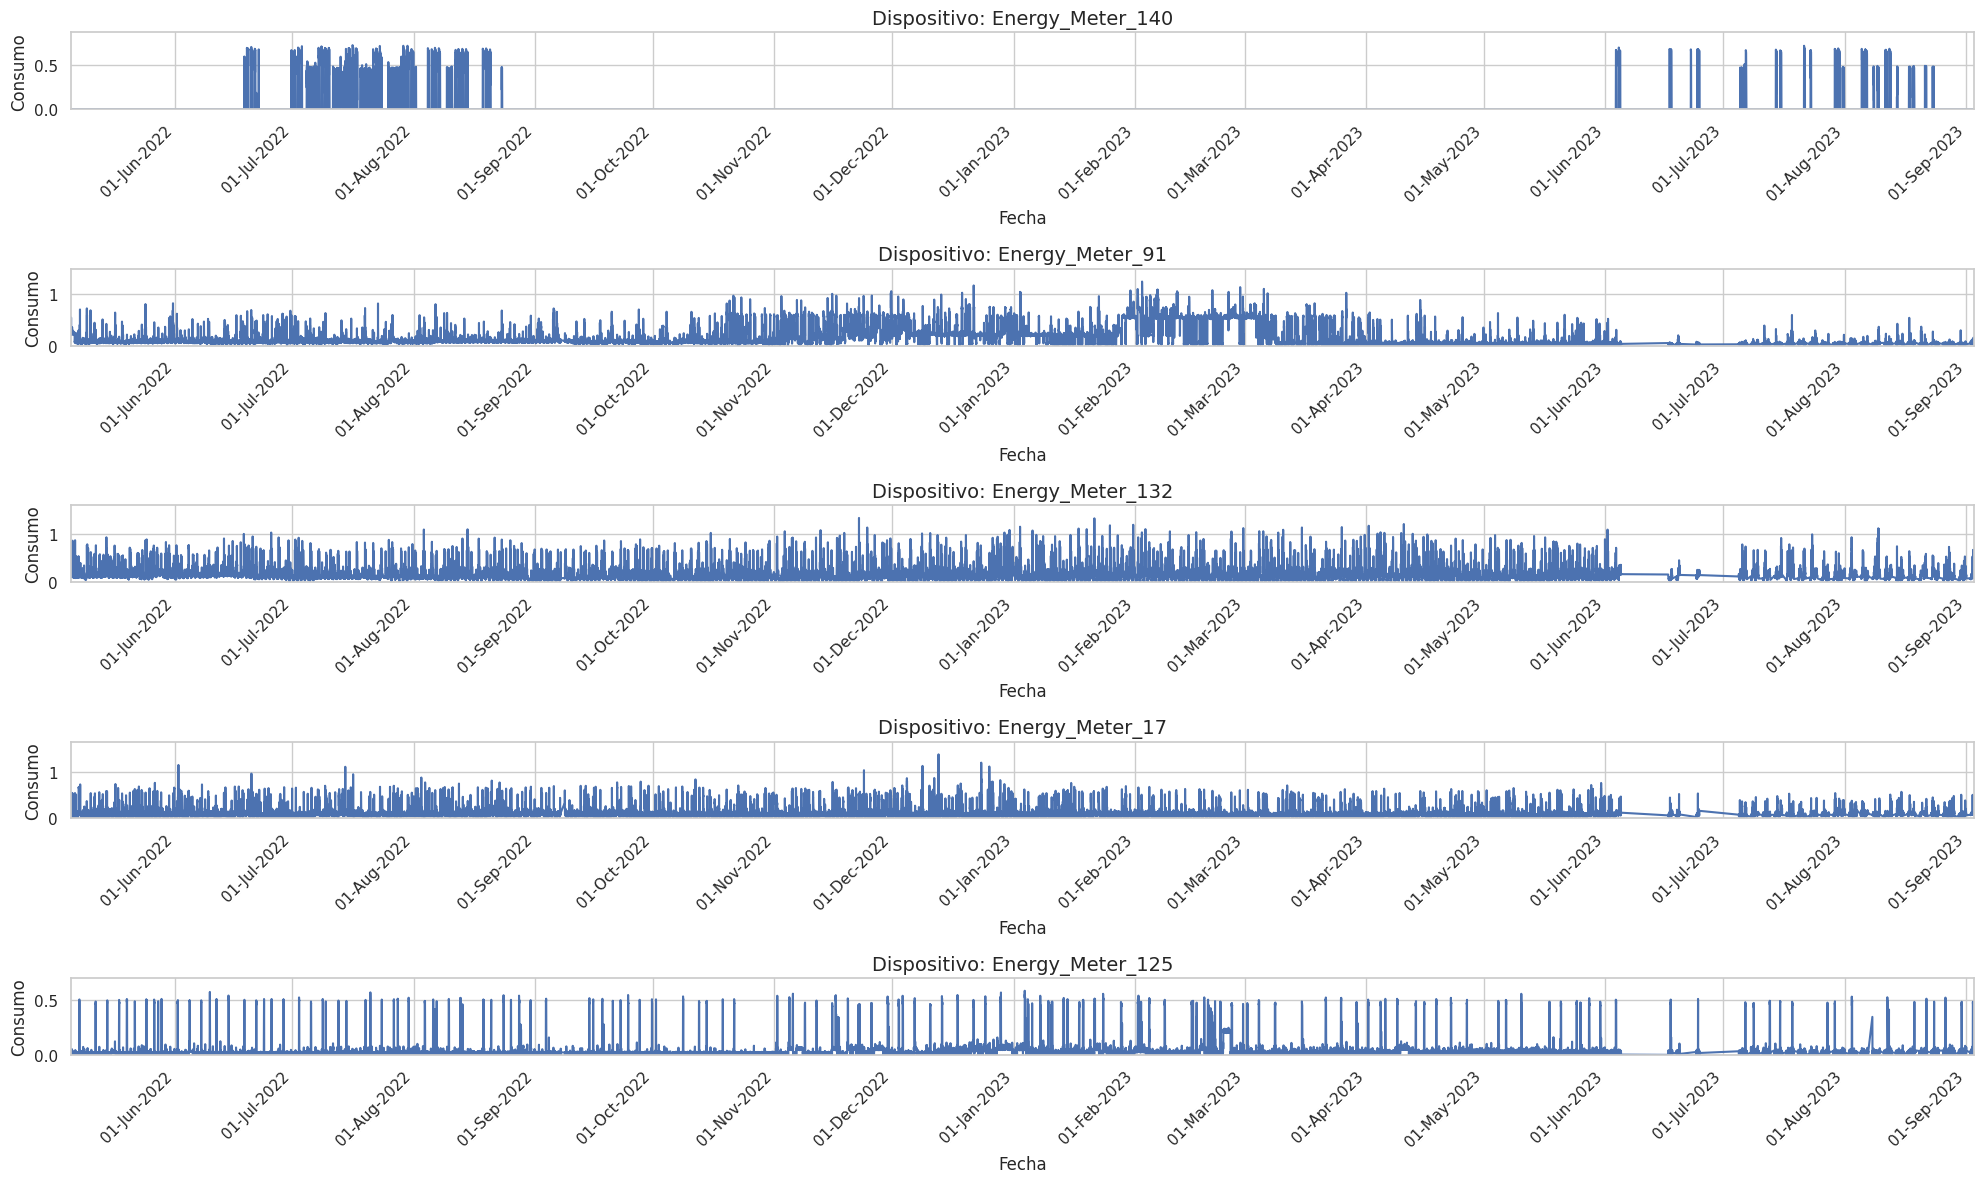

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns



# Seleccionar los dispositivos con menor porcentaje de valores faltantes
low_value_meters = Porciento_nulos_dispositivos.sort_values(ascending=True).index[0:5]

# Crear subgráficos
fig, ax = plt.subplots(nrows=5, figsize=(20, 12))  # Incrementar altura general con figsize

# Iterar sobre las columnas seleccionadas
for i, column in enumerate(low_value_meters):
    print(column)
    # Crear el gráfico de líneas
    plot1 = sns.lineplot(data=data_energy[column], ax=ax[i])
    plot1.set_xlim(data_energy.index.min(), data_energy.index.max())
    
    # Ajustar rango del eje Y (altura)
    ax[i].set_ylim(bottom=0, top=data_energy[column].max() * 1.2)  # Incrementa 20% el máximo

    # Formato del eje X para mostrar día, mes y año
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))  # Formato: Día-Mes-Año
    ax[i].xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Cada mes (ajustable)

    # Rotar etiquetas del eje X
    plt.setp(ax[i].xaxis.get_majorticklabels(), rotation=45, ha="right")

    # Etiqueta y título del subgráfico
    ax[i].set_title(f"Dispositivo: {column}", fontsize=14)
    ax[i].set_xlabel("Fecha", fontsize=12)
    ax[i].set_ylabel("Consumo", fontsize=12)

# Ajustar los márgenes
plt.tight_layout()
plt.show()


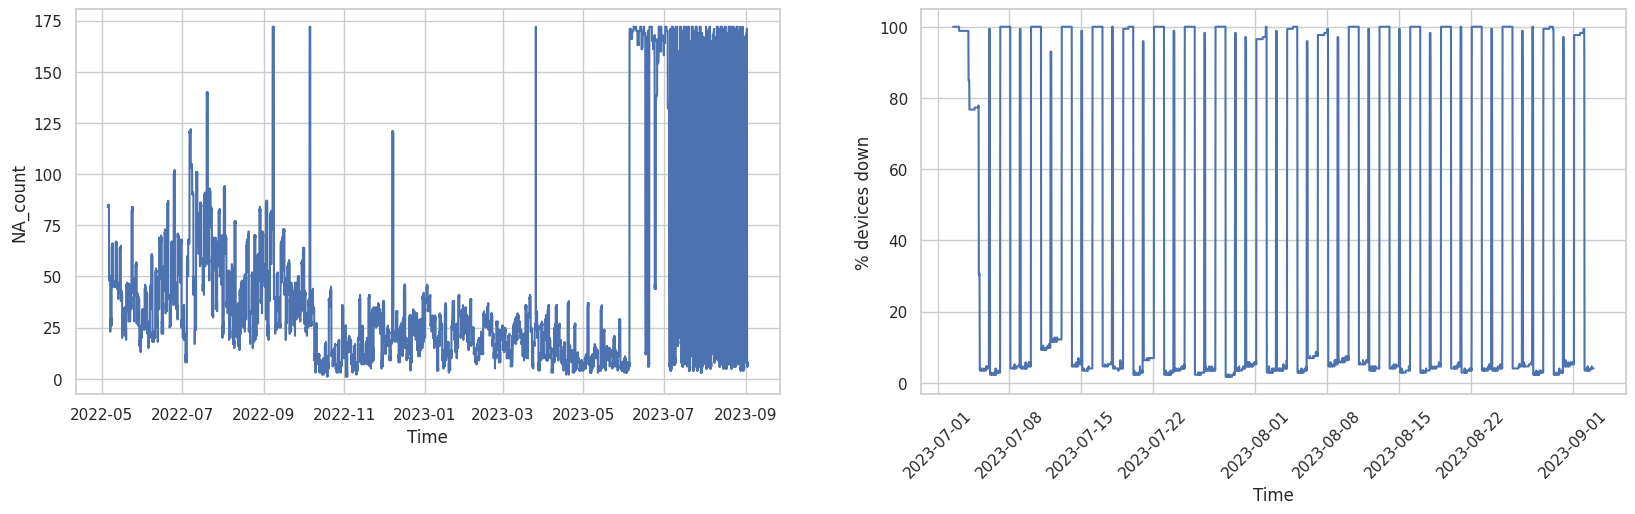

In [19]:
# flutuación  funcionamiento PLC

nan_by_date = data_energy.isna().sum(axis=1)
nan_by_date = nan_by_date.rename("NA_count").reset_index()
perc_nan_by_date = nan_by_date.copy()
perc_nan_by_date.NA_count = 100*perc_nan_by_date.NA_count/172

fig, ax = plt.subplots(ncols=2, figsize=(20,5))
sns.lineplot(nan_by_date, x="Time", y="NA_count", ax = ax[0])
sns.lineplot(perc_nan_by_date[-6000:], x="Time", y="NA_count", ax = ax[1])
ax[1].set_ylabel("% devices down")
ax[1].tick_params(axis='x', rotation=45)
plt.savefig("../Energia/img/peridomalfunci.png", dpi=300, bbox_inches='tight')

In [20]:
# hacer un merge de ambos dataset 
data_energy_merge =df_energy.copy()
data_weather_merge= df_weather.copy()

#data_energy_merge['Time'] = pd.to_datetime(data_energy_merge['Time'])
#data_weather_merge['Time'] = pd.to_datetime(data_weather_merge['Time'])

#data_energy_merge=data_energy_merge.set_index('Time', inplace=True)
#data_weather_merg=data_weather_merge.set_index('Time', inplace=True)

# Cargar los datasets
data_energy = pd.read_csv('loureiro_energy.csv', parse_dates=['Time'], index_col='Time')
data_weather = pd.read_csv('weather_aveiro_final.csv', parse_dates=['Time'], index_col='Time')


# Asegurarse de que la columna Time esté en formato datetime y como índice
data_energy.index = pd.to_datetime(data_energy.index, errors='coerce')
data_weather.index = pd.to_datetime(data_weather.index, errors='coerce')

# Realizar el merge de los datasets por la columna 'Time'
combined_data = pd.merge(data_energy_merge, data_weather_merge, on='Time', how='inner')

# Verificar que el merge fue exitoso
print("\nPrimeras filas de combined_data:")
print(combined_data.head())

# Verificar los tipos de datos después del merge
print("\nTipos de datos en combined_data:")
print(combined_data.dtypes)

# Resumen del dataset combinado
print("\nResumen del dataset combinado:")
print(combined_data.info())

# Guardar el resultado del merge en un nuevo archivo CSV (opcional)
combined_data.to_csv('combined_data.csv', index=True)



Primeras filas de combined_data:
                  Time  Energy_Meter_1  Energy_Meter_2  Energy_Meter_3  Energy_Meter_4  Energy_Meter_5  Energy_Meter_6  Energy_Meter_7  Energy_Meter_8  Energy_Meter_9  Energy_Meter_10  Energy_Meter_11  Energy_Meter_12  Energy_Meter_13  Energy_Meter_14  Energy_Meter_15  Energy_Meter_16  Energy_Meter_17  Energy_Meter_18  Energy_Meter_19  Energy_Meter_20  Energy_Meter_21  Energy_Meter_22  Energy_Meter_23  Energy_Meter_24  Energy_Meter_25  Energy_Meter_26  Energy_Meter_27  Energy_Meter_28  Energy_Meter_29  Energy_Meter_30  Energy_Meter_31  Energy_Meter_32  Energy_Meter_33  Energy_Meter_34  Energy_Meter_35  Energy_Meter_36  Energy_Meter_37  Energy_Meter_38  Energy_Meter_39  Energy_Meter_40  Energy_Meter_41  Energy_Meter_42  Energy_Meter_43  Energy_Meter_44  Energy_Meter_45  Energy_Meter_46  Energy_Meter_47  Energy_Meter_48  Energy_Meter_49  Energy_Meter_50  Energy_Meter_51  Energy_Meter_52  Energy_Meter_53  Energy_Meter_54  Energy_Meter_55  Energy_Meter_56 

In [21]:
# Seleccionar las 10 columnas Energy_Meter con mayor cantidad de valores mayores que 0 y menor cantidad de nulos
# Seleccionar las columnas de Energy_Meter y las columnas adicionales
energy_columns = [col for col in combined_data.columns if "Energy_Meter" in col]
additional_columns = [
    "Time","Avg_Temp", "Avg_Rel_Humidity", "Avg_Wind_Direction", "Avg_Wind_Speed", 
    "Max_Inst_Wind_Speed", "Inst_Temp", "Quantity_Precip", "Max_Inst_Precip", 
    "Total_Global_Rad"
]

# Contar valores mayores que 0 y valores nulos para las columnas de Energy_Meter
energy_metrics = pd.DataFrame({
    "non_zero_count": (combined_data[energy_columns] > 0).sum(),
    "null_count": combined_data[energy_columns].isnull().sum()
})

# Seleccionar las 10 columnas con mayor cantidad de valores mayores que 0 y menor cantidad de nulos
selected_energy_columns = (
    energy_metrics
    .sort_values(by=["non_zero_count", "null_count"], ascending=[False, True])
    .head(10)
    .index
)

# Crear un nuevo dataset con las columnas seleccionadas y las adicionales
selected_columns = list(selected_energy_columns) + additional_columns
new_dataset = combined_data[selected_columns]

# Verificar las primeras filas del nuevo dataset
print(new_dataset.head())
print(new_dataset.info())
# Guardar el nuevo dataset en un archivo CSV (opcional)
new_dataset.to_csv("new_dataset.csv", index=True)


   Energy_Meter_91  Energy_Meter_132  Energy_Meter_90  Energy_Meter_35  Energy_Meter_1  Energy_Meter_17  Energy_Meter_148  Energy_Meter_108  Energy_Meter_118  Energy_Meter_2                 Time  Avg_Temp  Avg_Rel_Humidity  Avg_Wind_Direction  Avg_Wind_Speed  Max_Inst_Wind_Speed  Inst_Temp  Quantity_Precip  Max_Inst_Precip  Total_Global_Rad
0            0.236             0.410            0.016            0.080           0.068            0.055             0.060             0.036               NaN             NaN  2022-05-05 12:00:00     22.70              62.0               305.0            3.80                 5.40      24.40              0.0              0.0            526.00
1            0.219             0.307            0.043            0.056           0.070            0.060             0.078             0.048               NaN             NaN  2022-05-05 12:15:00     22.55              63.5               311.5            4.05                 5.70      24.55              0.0       

In [22]:
# Asegúrate de que new_dataset es una copia independiente
new_dataset = new_dataset.copy()

# Convertir 'Time' a datetime
new_dataset['Time'] = pd.to_datetime(new_dataset['Time'])

# Establecer 'Time' como índice
new_dataset = new_dataset.set_index('Time')

# Ver información del DataFrame
new_dataset.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 46608 entries, 2022-05-05 12:00:00 to 2023-09-02 23:45:00
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Energy_Meter_91      41840 non-null  float64
 1   Energy_Meter_132     41839 non-null  float64
 2   Energy_Meter_90      41824 non-null  float64
 3   Energy_Meter_35      41822 non-null  float64
 4   Energy_Meter_1       41822 non-null  float64
 5   Energy_Meter_17      41837 non-null  float64
 6   Energy_Meter_148     41806 non-null  float64
 7   Energy_Meter_108     41774 non-null  float64
 8   Energy_Meter_118     41743 non-null  float64
 9   Energy_Meter_2       41748 non-null  float64
 10  Avg_Temp             46602 non-null  float64
 11  Avg_Rel_Humidity     46602 non-null  float64
 12  Avg_Wind_Direction   46608 non-null  float64
 13  Avg_Wind_Speed       46608 non-null  float64
 14  Max_Inst_Wind_Speed  46608 non-null  float64
 15  I

In [23]:
resumen_estadistico = new_dataset.describe()
# Resumen estadístico del dataset
resumen_estadistico = new_dataset.describe()

# Mostrar el resumen
print(resumen_estadistico)


       Energy_Meter_91  Energy_Meter_132  Energy_Meter_90  Energy_Meter_35  Energy_Meter_1  Energy_Meter_17  Energy_Meter_148  Energy_Meter_108  Energy_Meter_118  Energy_Meter_2      Avg_Temp  Avg_Rel_Humidity  Avg_Wind_Direction  Avg_Wind_Speed  Max_Inst_Wind_Speed     Inst_Temp  Quantity_Precip  Max_Inst_Precip  Total_Global_Rad
count     41840.000000      41839.000000     41824.000000     41822.000000    41822.000000     41837.000000      41806.000000      41774.000000      41743.000000    41748.000000  46602.000000      46602.000000        46608.000000    46608.000000         46608.000000  46603.000000     46608.000000     46608.000000      46603.000000
mean          0.151589          0.137682         0.079178         0.049600        0.092643         0.106709          0.047355          0.119973          0.074043        0.062613     17.475586         79.029602          203.658224        3.324001             5.127167     19.899899         0.015396         0.071608        123.178599
s

In [24]:
# Lista de variables meteorológicas
import pandas as pd

# Lista de variables meteorológicas
weather_variables = [
    'Avg_Temp', 'Avg_Rel_Humidity', 'Avg_Wind_Direction', 'Avg_Wind_Speed',
    'Max_Inst_Wind_Speed', 'Inst_Temp', 'Quantity_Precip', 'Max_Inst_Precip',
    'Total_Global_Rad'
]

# Resumen estadístico para las variables meteorológicas
resumen_estadistico_weather = new_dataset[weather_variables].describe()

# Redondear los valores para hacer las columnas más estrechas
resumen_estadistico_weather = resumen_estadistico_weather.round(2)

# Ajustar opciones de visualización
pd.set_option('display.max_columns', None)  # Asegura mostrar todas las columnas
pd.set_option('display.width', 100)        # Ajusta el ancho total de impresión
pd.set_option('display.float_format', '{:.2f}'.format)  # Control de formato decimal

# Mostrar el resumen
print(resumen_estadistico_weather)




       Avg_Temp  Avg_Rel_Humidity  Avg_Wind_Direction  Avg_Wind_Speed  Max_Inst_Wind_Speed  \
count  46602.00          46602.00            46608.00        46608.00             46608.00   
mean      17.48             79.03              203.66            3.32                 5.13   
std        4.36             14.21              113.75            2.05                 2.94   
min        1.60             19.50                0.00            0.10                 0.20   
25%       14.90             71.00              122.50            1.70                 2.80   
50%       17.80             82.00              194.00            2.90                 4.60   
75%       20.30             90.00              321.00            4.50                 6.80   
max       38.40            100.00              360.00           14.20                22.40   

       Inst_Temp  Quantity_Precip  Max_Inst_Precip  Total_Global_Rad  
count   46603.00         46608.00         46608.00          46603.00  
mean       

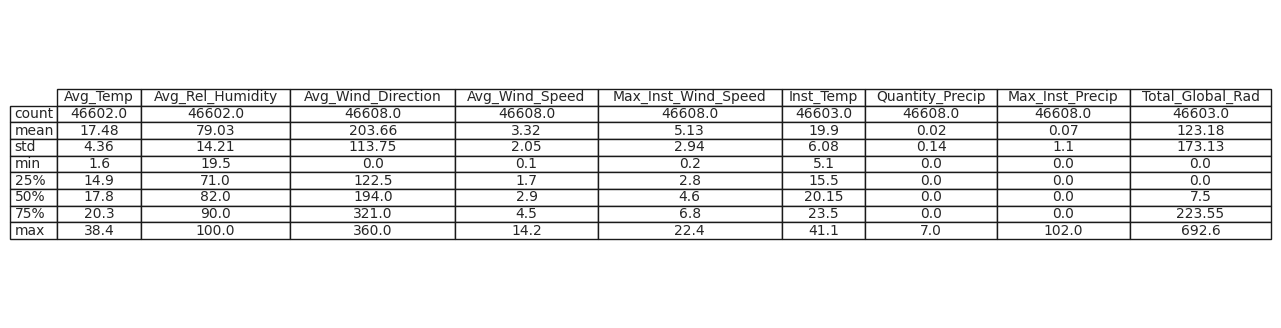

In [25]:


# Lista de variables meteorológicas
weather_variables = [
    'Avg_Temp', 'Avg_Rel_Humidity', 'Avg_Wind_Direction', 'Avg_Wind_Speed',
    'Max_Inst_Wind_Speed', 'Inst_Temp', 'Quantity_Precip', 'Max_Inst_Precip',
    'Total_Global_Rad'
]

# Resumen estadístico para las variables meteorológicas
resumen_estadistico_weather = new_dataset[weather_variables].describe()

# Redondear los valores para hacer las columnas más estrechas
resumen_estadistico_weather = resumen_estadistico_weather.round(2)

# Configurar la tabla en un gráfico de matplotlib
fig, ax = plt.subplots(figsize=(10, 4))  # Ajustar tamaño del gráfico
ax.axis('tight')
ax.axis('off')
tabla = plt.table(
    cellText=resumen_estadistico_weather.values,
    colLabels=resumen_estadistico_weather.columns,
    rowLabels=resumen_estadistico_weather.index,
    cellLoc='center',
    loc='center'
)
tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.auto_set_column_width(col=list(range(len(resumen_estadistico_weather.columns))))

# Guardar la tabla como archivo PNG
plt.savefig("../Energia/img/resumen_estadistico_weather.png", dpi=300, bbox_inches="tight")
plt.show()


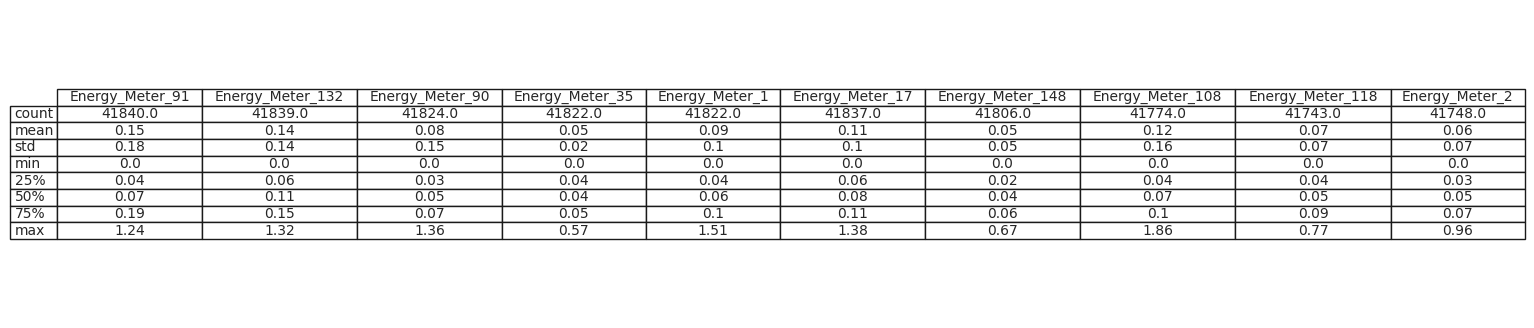

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Lista de columnas de Energy_Meter
energy_columns = [
    'Energy_Meter_91', 'Energy_Meter_132', 'Energy_Meter_90', 'Energy_Meter_35',
    'Energy_Meter_1', 'Energy_Meter_17', 'Energy_Meter_148', 'Energy_Meter_108',
    'Energy_Meter_118', 'Energy_Meter_2'
]

# Resumen estadístico para las columnas de Energy_Meter
resumen_estadistico_energy = new_dataset[energy_columns].describe()

# Redondear los valores para hacer las columnas más estrechas
resumen_estadistico_energy = resumen_estadistico_energy.round(2)

# Configurar la tabla en un gráfico de matplotlib
fig, ax = plt.subplots(figsize=(10, 4))  # Ajustar tamaño del gráfico
ax.axis('tight')
ax.axis('off')
tabla = plt.table(
    cellText=resumen_estadistico_energy.values,
    colLabels=resumen_estadistico_energy.columns,
    rowLabels=resumen_estadistico_energy.index,
    cellLoc='center',
    loc='center'
)
tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.auto_set_column_width(col=list(range(len(resumen_estadistico_energy.columns))))

# Guardar la tabla como archivo PNG
plt.savefig("resumen_estadistico_energy.png", dpi=300, bbox_inches="tight")
plt.show()


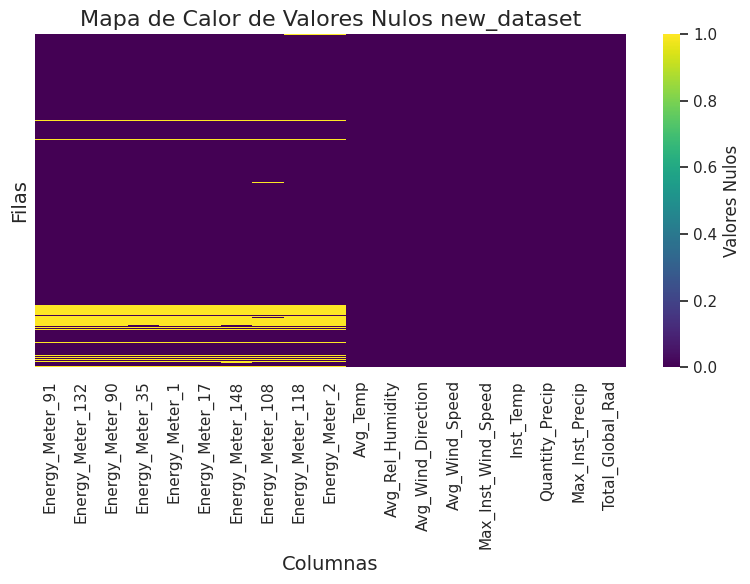

In [27]:
#Crear un mapa de calor para los valores nulos del nuevo dataset 

plt.figure(figsize=(8,6))  # Tamaño del gráfico
sns.heatmap(new_dataset.isnull(), 
            cbar=True,  # Mostrar barra de colores
            cmap="viridis",  # Paleta de colores
            yticklabels=False,  # Quitar etiquetas del eje Y
            cbar_kws={"label": "Valores Nulos"})  # Etiqueta de la barra de color

# Configurar el título y ejes
plt.title("Mapa de Calor de Valores Nulos new_dataset", fontsize=16)
plt.xlabel("Columnas", fontsize=14)
plt.ylabel("Filas", fontsize=14)

# Mostrar el gráfico
plt.tight_layout()

# Guardar el gráfico como imagen PNG
plt.savefig("../Energia/img/mapa_nulos_new_dataset.png", dpi=300, bbox_inches='tight')
plt.show()

48047
109703


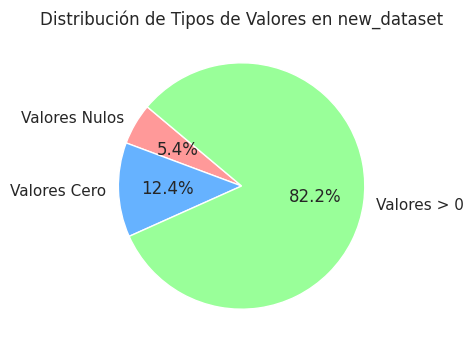

In [28]:
# Calcular el total de valores
total_values = new_dataset.size

# Calcular valores nulos, ceros y mayores que cero
null_values = new_dataset.isnull().sum().sum()
zero_values = (new_dataset == 0).sum().sum()
greater_than_zero = total_values - null_values - zero_values

print(null_values)
print(zero_values)

# Calcular porcentajes
percentages = [
    (null_values / total_values) * 100,  # Porcentaje de nulos
    (zero_values / total_values) * 100,  # Porcentaje de ceros
    (greater_than_zero / total_values) * 100  # Porcentaje de valores > 0
]

# Etiquetas para el gráfico
labels = ['Valores Nulos', 'Valores Cero', 'Valores > 0']

# Crear el gráfico circular
plt.figure(figsize=(4, 4))
plt.pie(
    percentages, 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=['#FF9999', '#66B2FF', '#99FF99']
)
plt.title('Distribución de Tipos de Valores en new_dataset')

# Guardar el gráfico en un archivo
plt.savefig("../Energia/img/distribution_new_datasets.png", dpi=100, bbox_inches='tight')

# Mostrar el gráfico
plt.show()

In [29]:
from sklearn.impute import KNNImputer
import pandas as pd
import numpy as np

# Copia del dataset para trabajar
columns_to_impute = ['Avg_Temp', 'Avg_Rel_Humidity', 'Avg_Wind_Direction', 'Avg_Wind_Speed',
                     'Max_Inst_Wind_Speed', 'Inst_Temp', 'Quantity_Precip', 'Max_Inst_Precip', 'Total_Global_Rad']
data_energy_clean = new_dataset.copy()

# Crear el imputador KNN (k=5 vecinos más cercanos)
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')

# Imputar valores nulos únicamente en las columnas seleccionadas
data_energy_clean[columns_to_impute] = knn_imputer.fit_transform(data_energy_clean[columns_to_impute])

# Contar los valores faltantes restantes después de la imputación
valores_faltantes_post = data_energy_clean[columns_to_impute].isna().sum()

print("Valores faltantes por columna después de la imputación:")
print(valores_faltantes_post)

# Verificar si se imputaron todos los valores nulos
total_imputados = sum(new_dataset[columns_to_impute].isna().sum() - valores_faltantes_post)
print(f"Total de valores imputados: {total_imputados}")

Valores faltantes por columna después de la imputación:
Avg_Temp               0
Avg_Rel_Humidity       0
Avg_Wind_Direction     0
Avg_Wind_Speed         0
Max_Inst_Wind_Speed    0
Inst_Temp              0
Quantity_Precip        0
Max_Inst_Precip        0
Total_Global_Rad       0
dtype: int64
Total de valores imputados: 22


In [30]:
data_energy_clean.to_csv('data_energy_clean.csv', index=False)

In [31]:
# Filtrar las filas con valores no nulos en 'Avg_Rel_Humidity'
valores_no_nulos = data_energy_clean[data_energy_clean['Avg_Rel_Humidity'].notnull()]

# Identificar los valores que no están entre 0 y 100
valores_fuera_rango = valores_no_nulos[~valores_no_nulos['Avg_Rel_Humidity'].between(0, 100, inclusive='both')]

# Mostrar resultados
if valores_fuera_rango.empty:
    print("No se encontraron valores fuera del rango de 0 a 100 en 'Avg_Rel_Humidity'.")
else:
    print(f"Se encontraron {len(valores_fuera_rango)} valores fuera del rango en 'Avg_Rel_Humidity':")
    print(valores_fuera_rango[['Time', 'Avg_Rel_Humidity']])  # Mostrar solo columnas relevantes

No se encontraron valores fuera del rango de 0 a 100 en 'Avg_Rel_Humidity'.


In [32]:
# Comprobar si todos los valores están entre 0 y 360
dentro_rango = data_energy_clean['Avg_Wind_Direction'].between(0, 360, inclusive='both')

# Verificar si hay valores fuera del rango
valores_fuera_rango = data_energy_clean[~dentro_rango]

# Mostrar resultados
if valores_fuera_rango.empty:
    print("Todos los valores en 'Avg_Wind_Direction' están dentro del rango de 0 a 360 grados.")
else:
    print(f"Se encontraron {len(valores_fuera_rango)} valores fuera del rango de 0 a 360 grados:")
    print(valores_fuera_rango)


Todos los valores en 'Avg_Wind_Direction' están dentro del rango de 0 a 360 grados.


In [33]:
sum(data_energy_clean.isna().sum())
data_energy_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 46608 entries, 2022-05-05 12:00:00 to 2023-09-02 23:45:00
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Energy_Meter_91      41840 non-null  float64
 1   Energy_Meter_132     41839 non-null  float64
 2   Energy_Meter_90      41824 non-null  float64
 3   Energy_Meter_35      41822 non-null  float64
 4   Energy_Meter_1       41822 non-null  float64
 5   Energy_Meter_17      41837 non-null  float64
 6   Energy_Meter_148     41806 non-null  float64
 7   Energy_Meter_108     41774 non-null  float64
 8   Energy_Meter_118     41743 non-null  float64
 9   Energy_Meter_2       41748 non-null  float64
 10  Avg_Temp             46608 non-null  float64
 11  Avg_Rel_Humidity     46608 non-null  float64
 12  Avg_Wind_Direction   46608 non-null  float64
 13  Avg_Wind_Speed       46608 non-null  float64
 14  Max_Inst_Wind_Speed  46608 non-null  float64
 15  I

### Para determinar si existe una relación lineal entre las variables, hago correlación entre las columnas meteorológicas y las 
    columnas de consumo de energía. Esto te permitirá identificar qué variables meteorológicas podrían tener un impacto directo sobre el consumo de         energía.

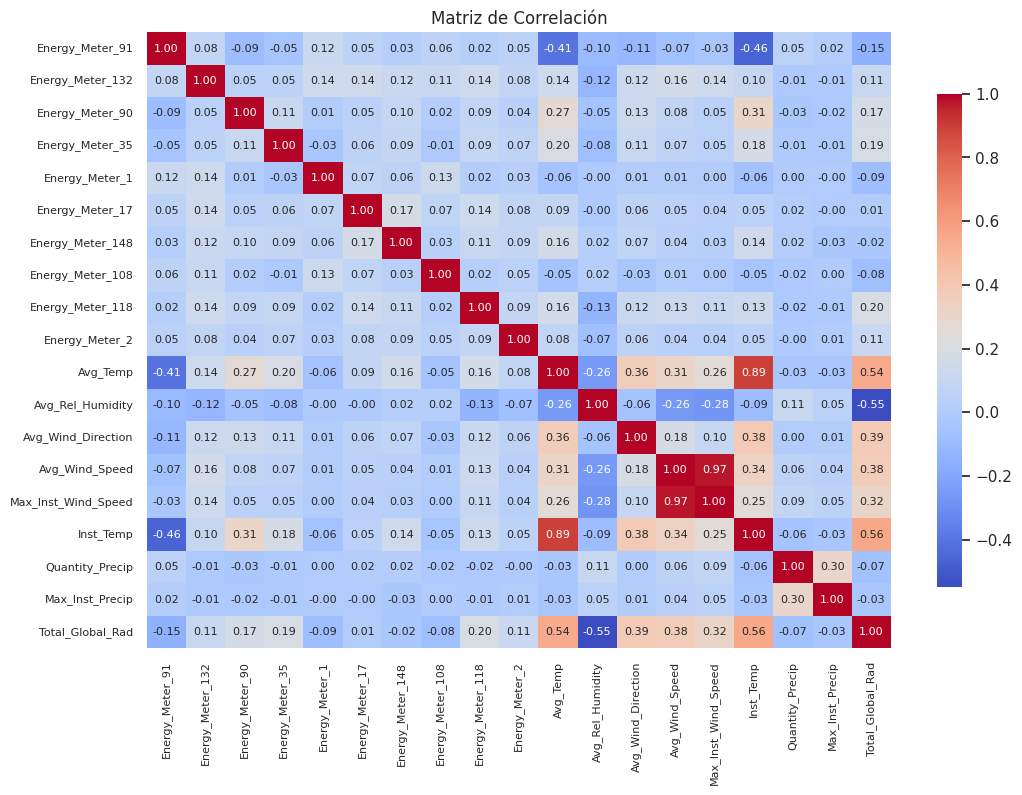

In [34]:
# Buscar correlación entre energy_columns y weather_columns
# Seleccionar columnas de medición de energía y meteorológicas
energy_columns = ['Energy_Meter_91', 'Energy_Meter_132', 'Energy_Meter_90', 'Energy_Meter_35', 
                  'Energy_Meter_1', 'Energy_Meter_17', 'Energy_Meter_148', 'Energy_Meter_108', 
                  'Energy_Meter_118', 'Energy_Meter_2']

weather_columns = ['Avg_Temp', 'Avg_Rel_Humidity', 'Avg_Wind_Direction', 'Avg_Wind_Speed', 
                   'Max_Inst_Wind_Speed', 'Inst_Temp', 'Quantity_Precip', 'Max_Inst_Precip', 'Total_Global_Rad']

# Calcular la correlación entre las columnas de energía y meteorológicas
correlation_matrix = data_energy_clean[energy_columns + weather_columns].corr()

# Crear el heatmap con rotulado más pequeño
plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,                        # Mostrar los valores en el mapa
    fmt=".2f",                         # Formato de los números (dos decimales)
    cmap="coolwarm",                   # Colormap
    annot_kws={"size": 8},             # Tamaño de fuente de las anotaciones
    cbar_kws={"shrink": 0.8}           # Ajustar el tamaño de la barra de color
)

# Ajustar el tamaño del rotulado de los ejes
plt.xticks(fontsize=8, rotation=90)    # Rotar etiquetas del eje x
plt.yticks(fontsize=8)                 # Tamaño de etiquetas del eje y
plt.title('Matriz de Correlación', fontsize=12)  # Título con tamaño ajustado
plt.savefig("../Energia/img/matrizcorrelacion.png", dpi=100, bbox_inches='tight')
plt.show()


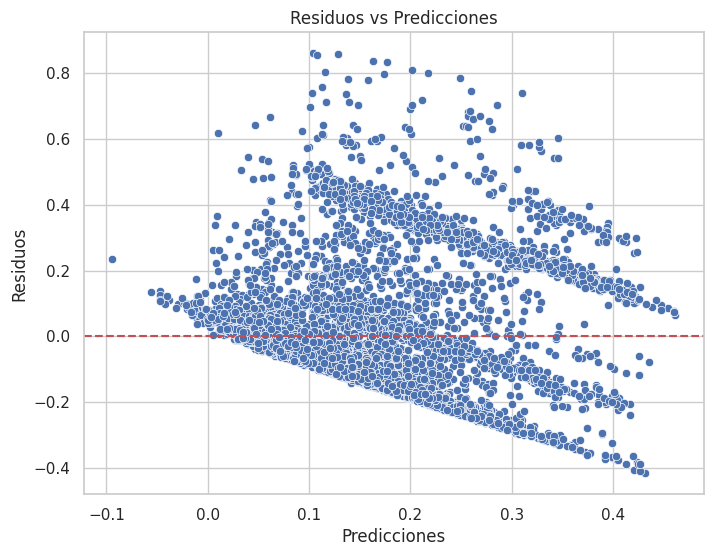

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar filas con valores nulos
data_energy_clean_nonull = data_energy_clean[['Avg_Temp', 'Avg_Rel_Humidity', 'Avg_Wind_Speed', 'Energy_Meter_91']].dropna()

# Selección de las columnas de entrada y salida
X = data_energy_clean_nonull[['Avg_Temp', 'Avg_Rel_Humidity', 'Avg_Wind_Speed']]  # Columnas meteorológicas
y = data_energy_clean_nonull['Energy_Meter_91']  # Columna de energía

# División de los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamiento de un modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Predicción de los valores de prueba
y_pred = model.predict(X_test)

# Cálculo de los residuos
residuos = y_test - y_pred

# Gráfico de los residuos
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuos)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residuos vs Predicciones')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.show()



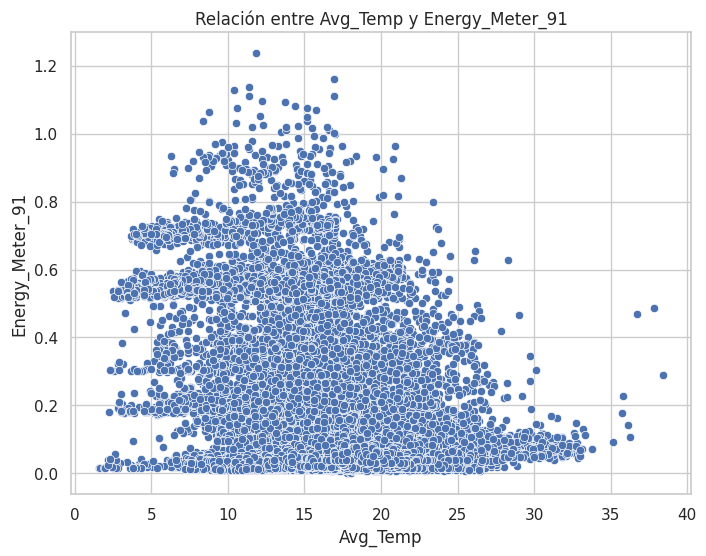

In [36]:
# Ejemplo de gráfico de dispersión entre Energy_Meter_91 y Avg_Temp
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_energy_clean['Avg_Temp'], y=data_energy_clean['Energy_Meter_91'])
plt.title('Relación entre Avg_Temp y Energy_Meter_91')
plt.xlabel('Avg_Temp')
plt.ylabel('Energy_Meter_91')
plt.show()


In [37]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# Selección de las columnas a imputar
columns_to_impute = [
    'Energy_Meter_91', 'Energy_Meter_132', 'Energy_Meter_90', 'Energy_Meter_35',
    'Energy_Meter_1', 'Energy_Meter_17', 'Energy_Meter_148', 'Energy_Meter_108',
    'Energy_Meter_118', 'Energy_Meter_2'
]

# Crear una copia del dataset para mantener los datos originales intactos
data_energy_knn = data_energy_clean.copy()

# Escalar los datos antes de aplicar KNN (opcional pero recomendado para variables en diferentes escalas)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_energy_knn[columns_to_impute])

# Imputación con KNN
knn_imputer = KNNImputer(n_neighbors=5)  # k=5 es un valor comúnmente usado
imputed_data = knn_imputer.fit_transform(scaled_data)

# Reescalado de los datos al rango original (opcional, si el modelo requiere datos sin escalar)
data_energy_knn[columns_to_impute] = scaler.inverse_transform(imputed_data)

# Verificación: Mostrar las columnas imputadas con los valores nulos eliminados
print(data_energy_knn[columns_to_impute].isnull().sum())


Energy_Meter_91     0
Energy_Meter_132    0
Energy_Meter_90     0
Energy_Meter_35     0
Energy_Meter_1      0
Energy_Meter_17     0
Energy_Meter_148    0
Energy_Meter_108    0
Energy_Meter_118    0
Energy_Meter_2      0
dtype: int64


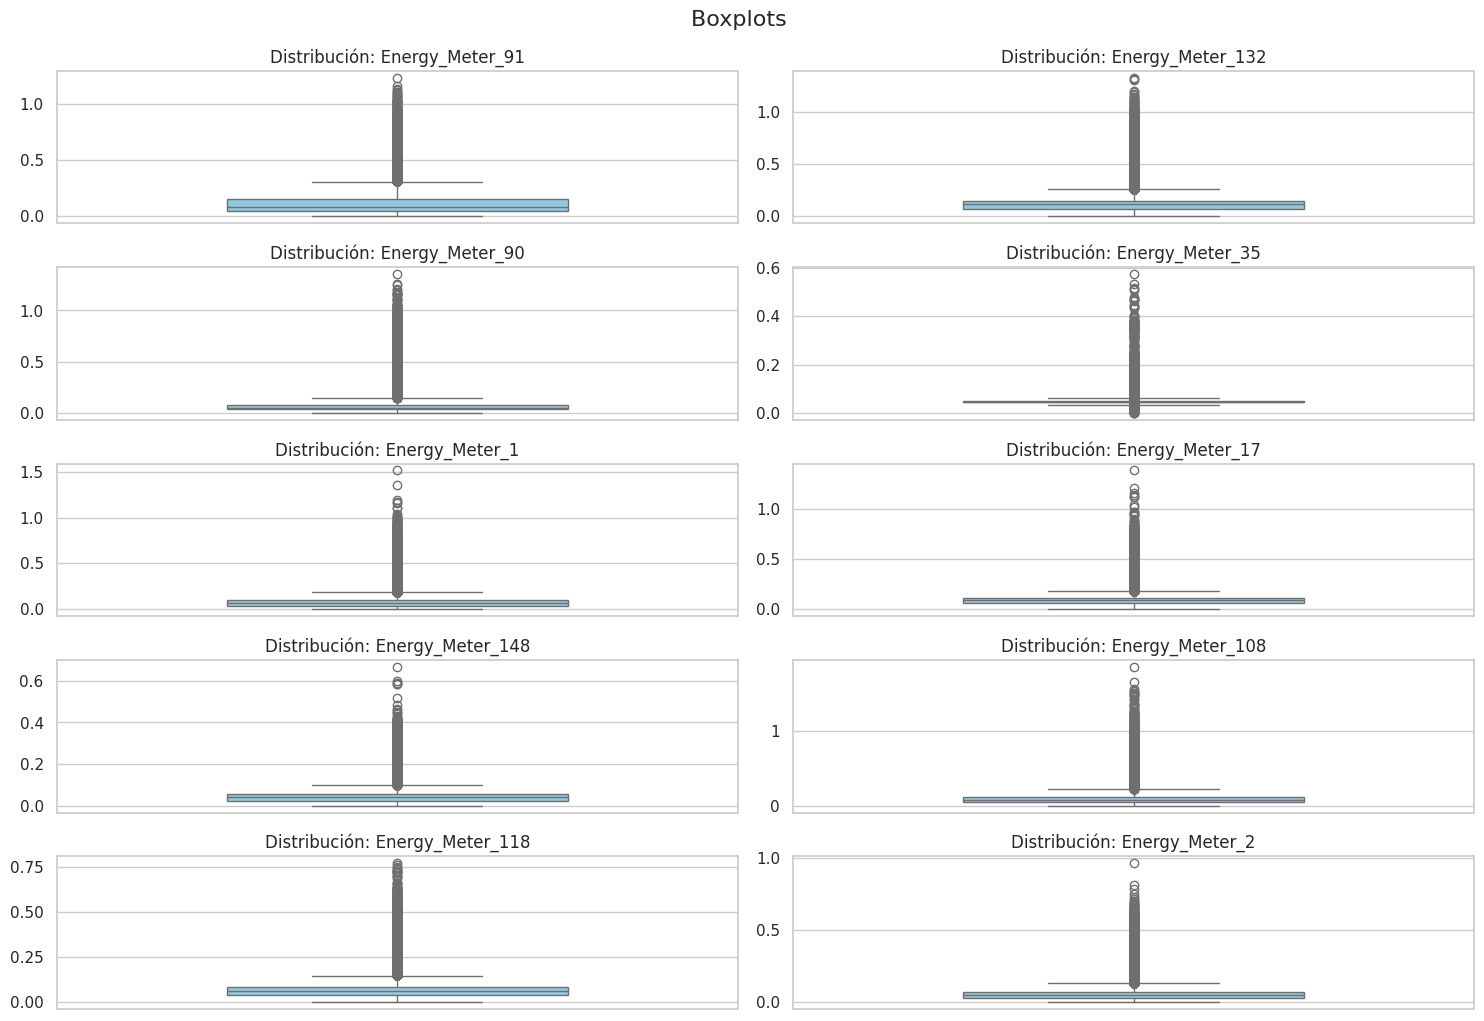

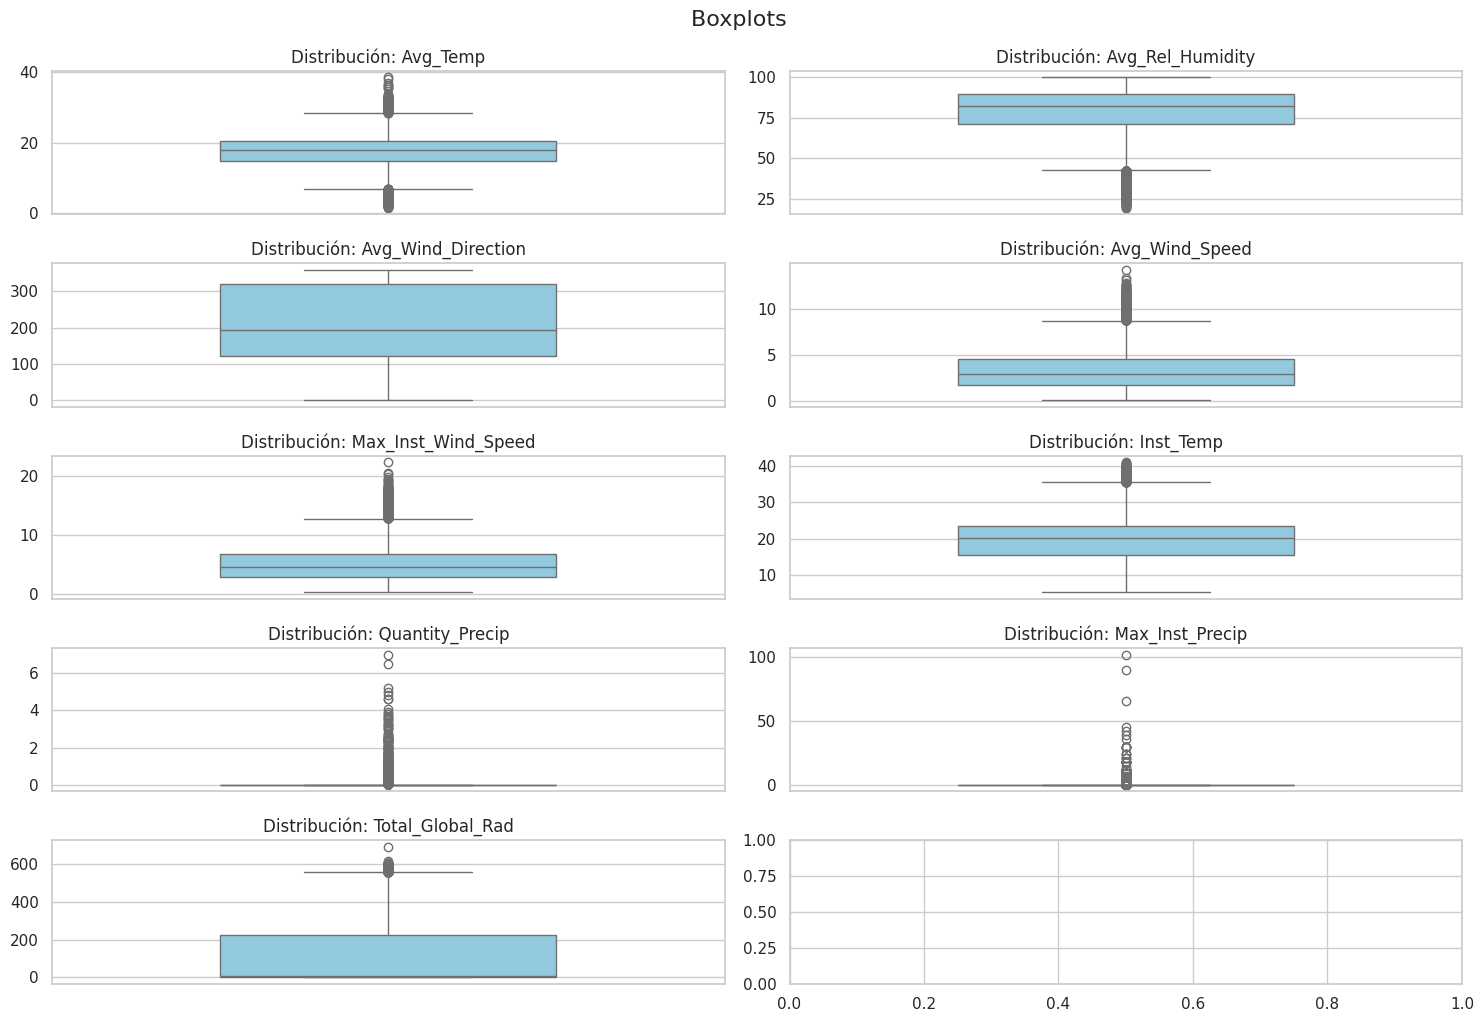

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplots con límite en el eje y
columnas_energia = [
    'Energy_Meter_91', 'Energy_Meter_132', 'Energy_Meter_90', 'Energy_Meter_35',
    'Energy_Meter_1', 'Energy_Meter_17', 'Energy_Meter_148', 'Energy_Meter_108',
    'Energy_Meter_118', 'Energy_Meter_2'
]

colomnas_weather=['Avg_Temp', 'Avg_Rel_Humidity',
 'Avg_Wind_Direction', 'Avg_Wind_Speed', 'Max_Inst_Wind_Speed',
 'Inst_Temp', 'Quantity_Precip', 'Max_Inst_Precip', 'Total_Global_Rad']

def boxplot_columns_fixed_ylim(dataset, columns, rows=5, cols=2, box_width=0.5, ylim_max=0.5):
    """
    Genera boxplots para un conjunto de columnas en una cuadrícula con límite fijo en el eje y.
    dataset: DataFrame.
    columns: Lista de columnas para incluir en los boxplots.
    rows: Número de filas en la cuadrícula.
    cols: Número de columnas en la cuadrícula.
    box_width: Ancho de las cajas en los boxplots.
    ylim_max: Valor máximo fijo para el eje y.
    """
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()  # Convertir a una lista para iterar fácilmente
    for i, column in enumerate(columns[:rows * cols]):  # Limitar al tamaño de la cuadrícula
        sns.boxplot(y=dataset[column], ax=axes[i], color='skyblue', width=box_width)
        # Establecer el límite fijo en el eje y
        #axes[i].set_ylim(0, ylim_max)
        axes[i].set_title(f'Distribución: {column}')
        axes[i].set_ylabel('')
    plt.tight_layout()
    plt.suptitle("Boxplots ", y=1.02, fontsize=16)
    plt.show()

# Llamar la función para boxplots

boxplot_columns_fixed_ylim(data_energy_knn, columnas_energia, rows=5, cols=2, box_width=0.5, ylim_max=1)
boxplot_columns_fixed_ylim(data_energy_knn, colomnas_weather, rows=5, cols=2, box_width=0.5)


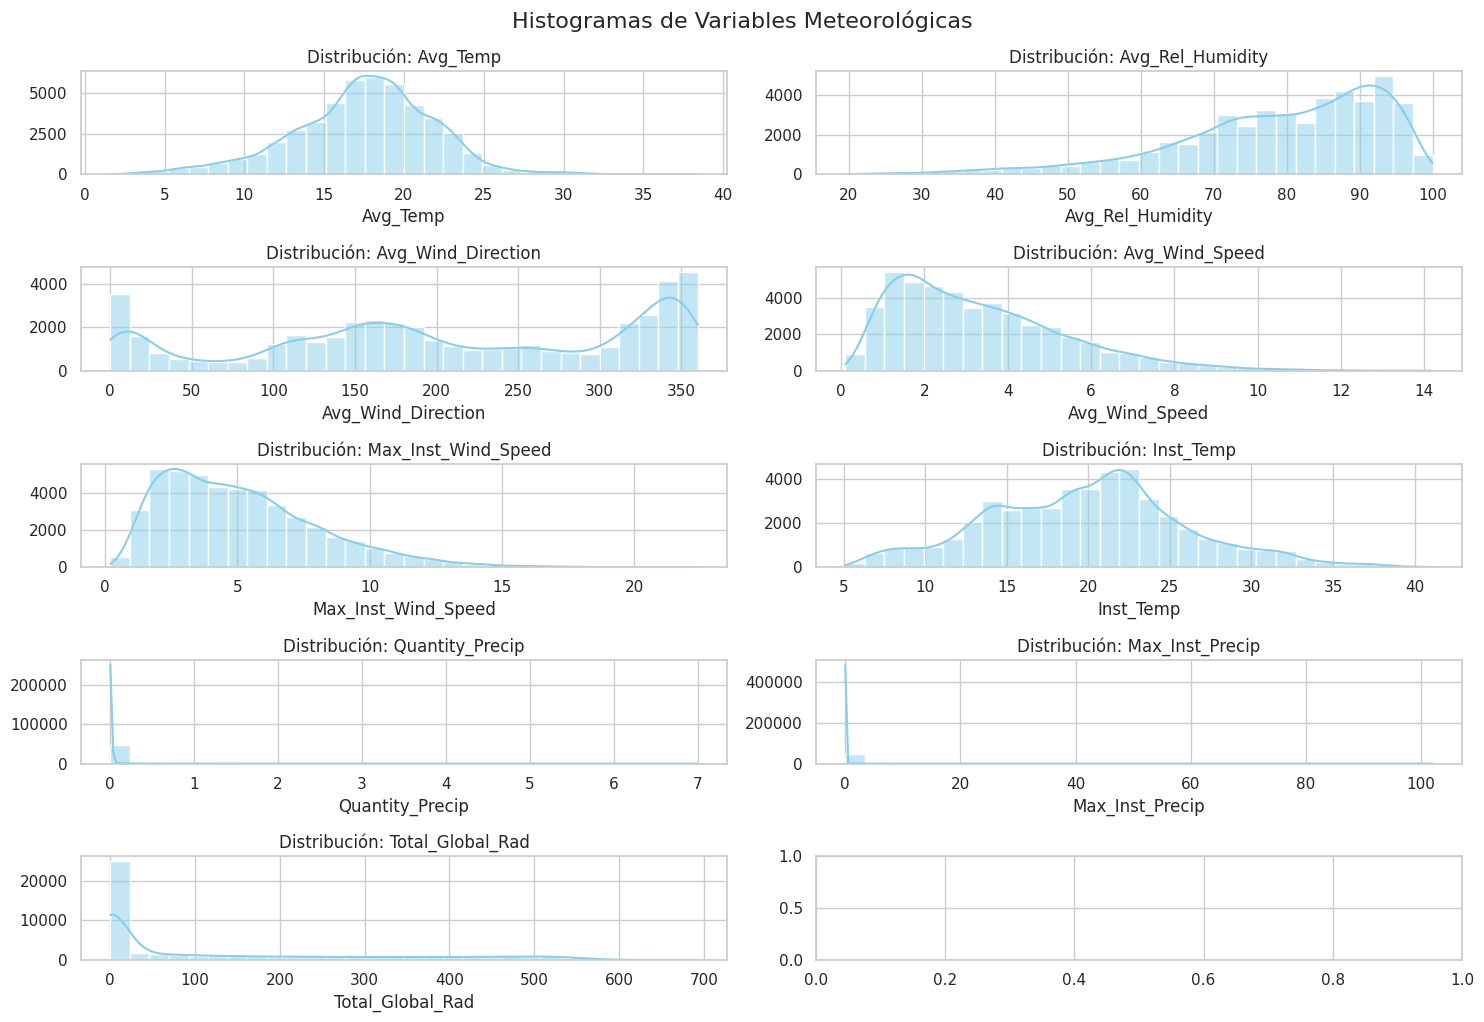

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Columnas meteorológicas
colomnas_weather = [
    'Avg_Temp', 'Avg_Rel_Humidity', 'Avg_Wind_Direction', 'Avg_Wind_Speed', 'Max_Inst_Wind_Speed',
    'Inst_Temp', 'Quantity_Precip', 'Max_Inst_Precip', 'Total_Global_Rad'
]

def histogram_columns(dataset, columns, rows=5, cols=2, bins=30):
    """
    Genera histogramas para un conjunto de columnas en una cuadrícula.
    dataset: DataFrame.
    columns: Lista de columnas para incluir en los histogramas.
    rows: Número de filas en la cuadrícula.
    cols: Número de columnas en la cuadrícula.
    bins: Número de bins para los histogramas.
    """
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()  # Convertir a una lista para iterar fácilmente
    for i, column in enumerate(columns[:rows * cols]):  # Limitar al tamaño de la cuadrícula
        sns.histplot(dataset[column], ax=axes[i], kde=True, bins=bins, color='skyblue')  # Generar histograma con KDE
        axes[i].set_title(f'Distribución: {column}')
        axes[i].set_ylabel('')
    plt.tight_layout()
    plt.suptitle("Histogramas de Variables Meteorológicas", y=1.02, fontsize=16)
    plt.show()

# Llamar la función para los histogramas de las columnas meteorológicas
histogram_columns(data_energy_knn, colomnas_weather, rows=5, cols=2, bins=30)


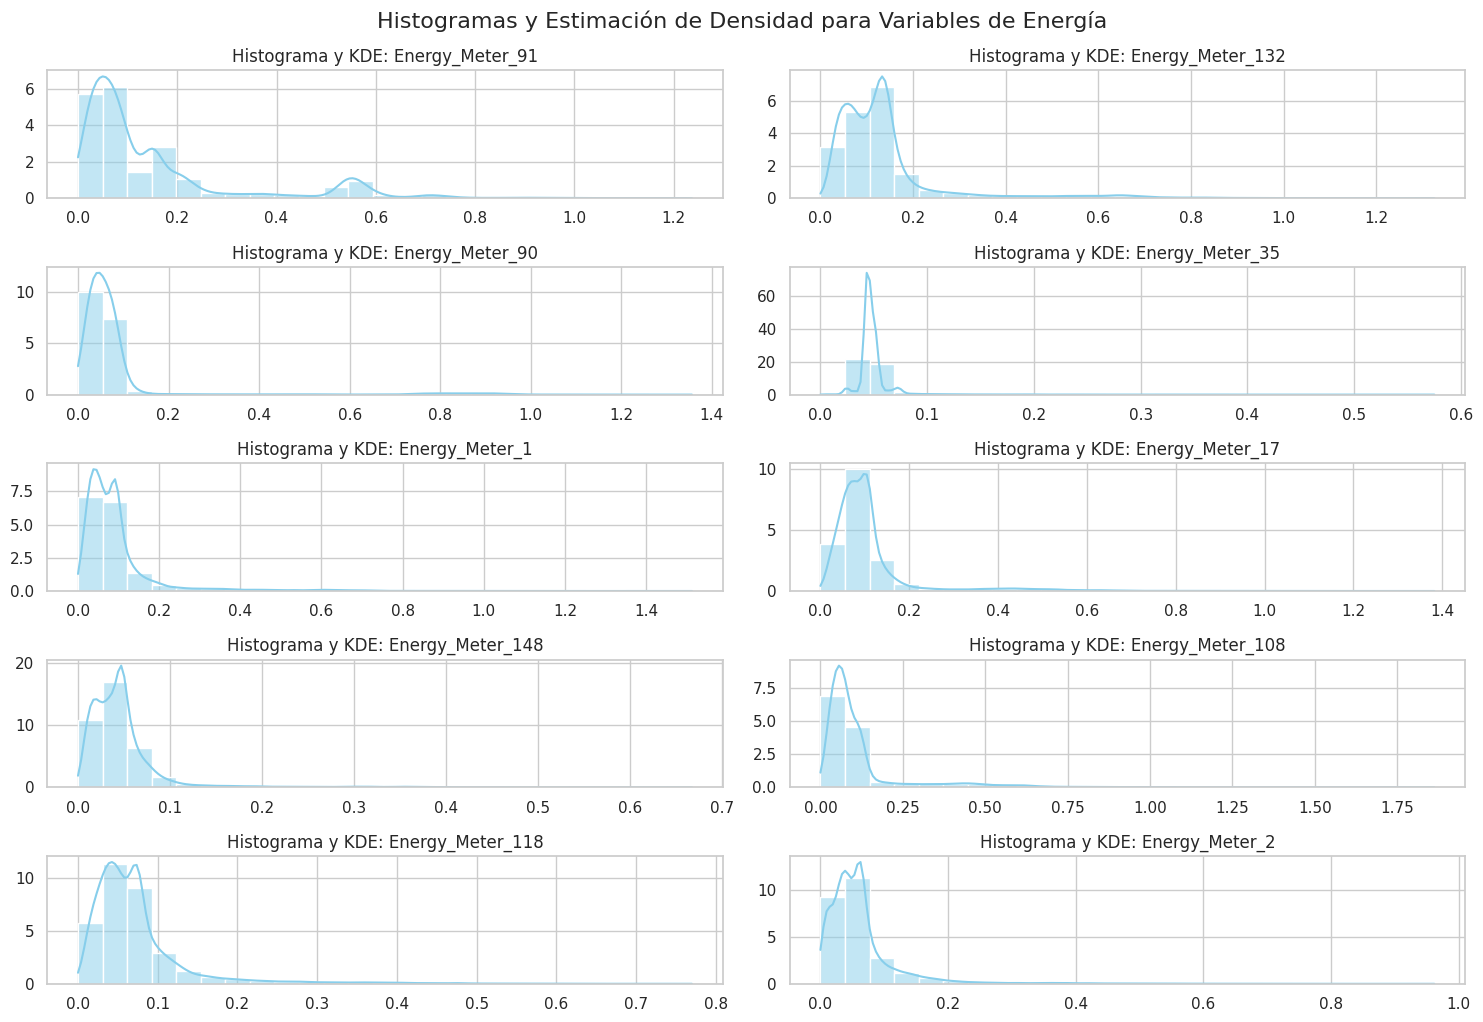

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definir las columnas de energía
columnas_energia = [
    'Energy_Meter_91', 'Energy_Meter_132', 'Energy_Meter_90', 'Energy_Meter_35',
    'Energy_Meter_1', 'Energy_Meter_17', 'Energy_Meter_148', 'Energy_Meter_108',
    'Energy_Meter_118', 'Energy_Meter_2'
]

def histogram_columns(dataset, columns, rows=5, cols=2, bins=20):
    """
    Genera histogramas para un conjunto de columnas en una cuadrícula.
    dataset: DataFrame.
    columns: Lista de columnas para incluir en los histogramas.
    rows: Número de filas en la cuadrícula.
    cols: Número de columnas en la cuadrícula.
    bins: Número de contenedores en el histograma.
    """
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()  # Convertir a una lista para iterar fácilmente
    for i, column in enumerate(columns[:rows * cols]):  # Limitar al tamaño de la cuadrícula
        sns.histplot(dataset[column], kde=True, ax=axes[i], bins=bins, color='skyblue', stat='density')
        axes[i].set_title(f'Histograma y KDE: {column}')
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
    plt.tight_layout()
    plt.suptitle("Histogramas y Estimación de Densidad para Variables de Energía", y=1.02, fontsize=16)
    plt.show()

# Llamar la función para generar los histogramas de las columnas de energía
histogram_columns(data_energy_knn, columnas_energia, rows=5, cols=2, bins=25)


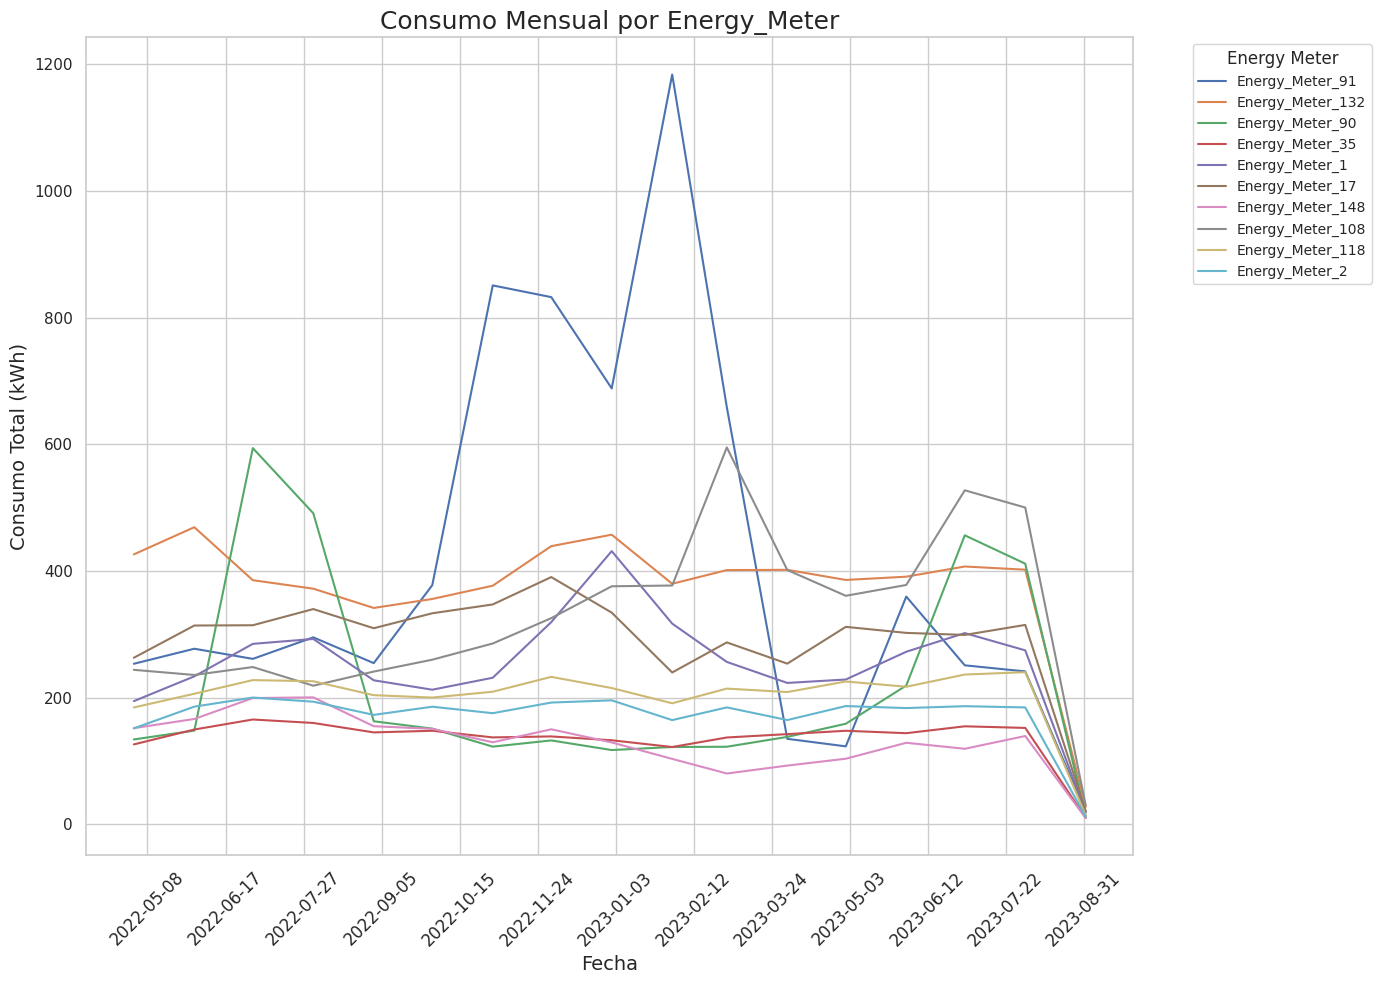

In [41]:



# Seleccionar las columnas de Energy_Meter
energy_columns = [col for col in data_energy_knn.columns if 'Energy_Meter' in col]

# Agrupar por año y mes usando groupby
monthly_consumption = data_energy_knn[energy_columns].groupby([data_energy_knn.index.year, data_energy_knn.index.month]).sum()

# Renombrar el índice para una mejor visualización
monthly_consumption.index = pd.to_datetime(monthly_consumption.index.map(lambda x: f'{x[0]}-{x[1]:02d}'), format='%Y-%m')

# Graficar el consumo mensual para cada Energy_Meter
plt.figure(figsize=(14, 10))
for column in energy_columns:
    sns.lineplot(data=monthly_consumption, x=monthly_consumption.index, y=column, label=column)

plt.title('Consumo Mensual por Energy_Meter', fontsize=18)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Consumo Total (kWh)', fontsize=14)

# Ajustar leyenda
plt.legend(title="Energy Meter", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Asegurar que todos los meses se muestren en el eje x
plt.xticks(rotation=45, fontsize=12)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(len(monthly_consumption.index)))  # Mostrar todas las etiquetas

plt.tight_layout()
plt.savefig("../Energia/img/series_mensual_modificado.png", dpi=300, bbox_inches='tight')
plt.show()


/tmp/ipykernel_214890/2313468067.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajuste para incluir el título


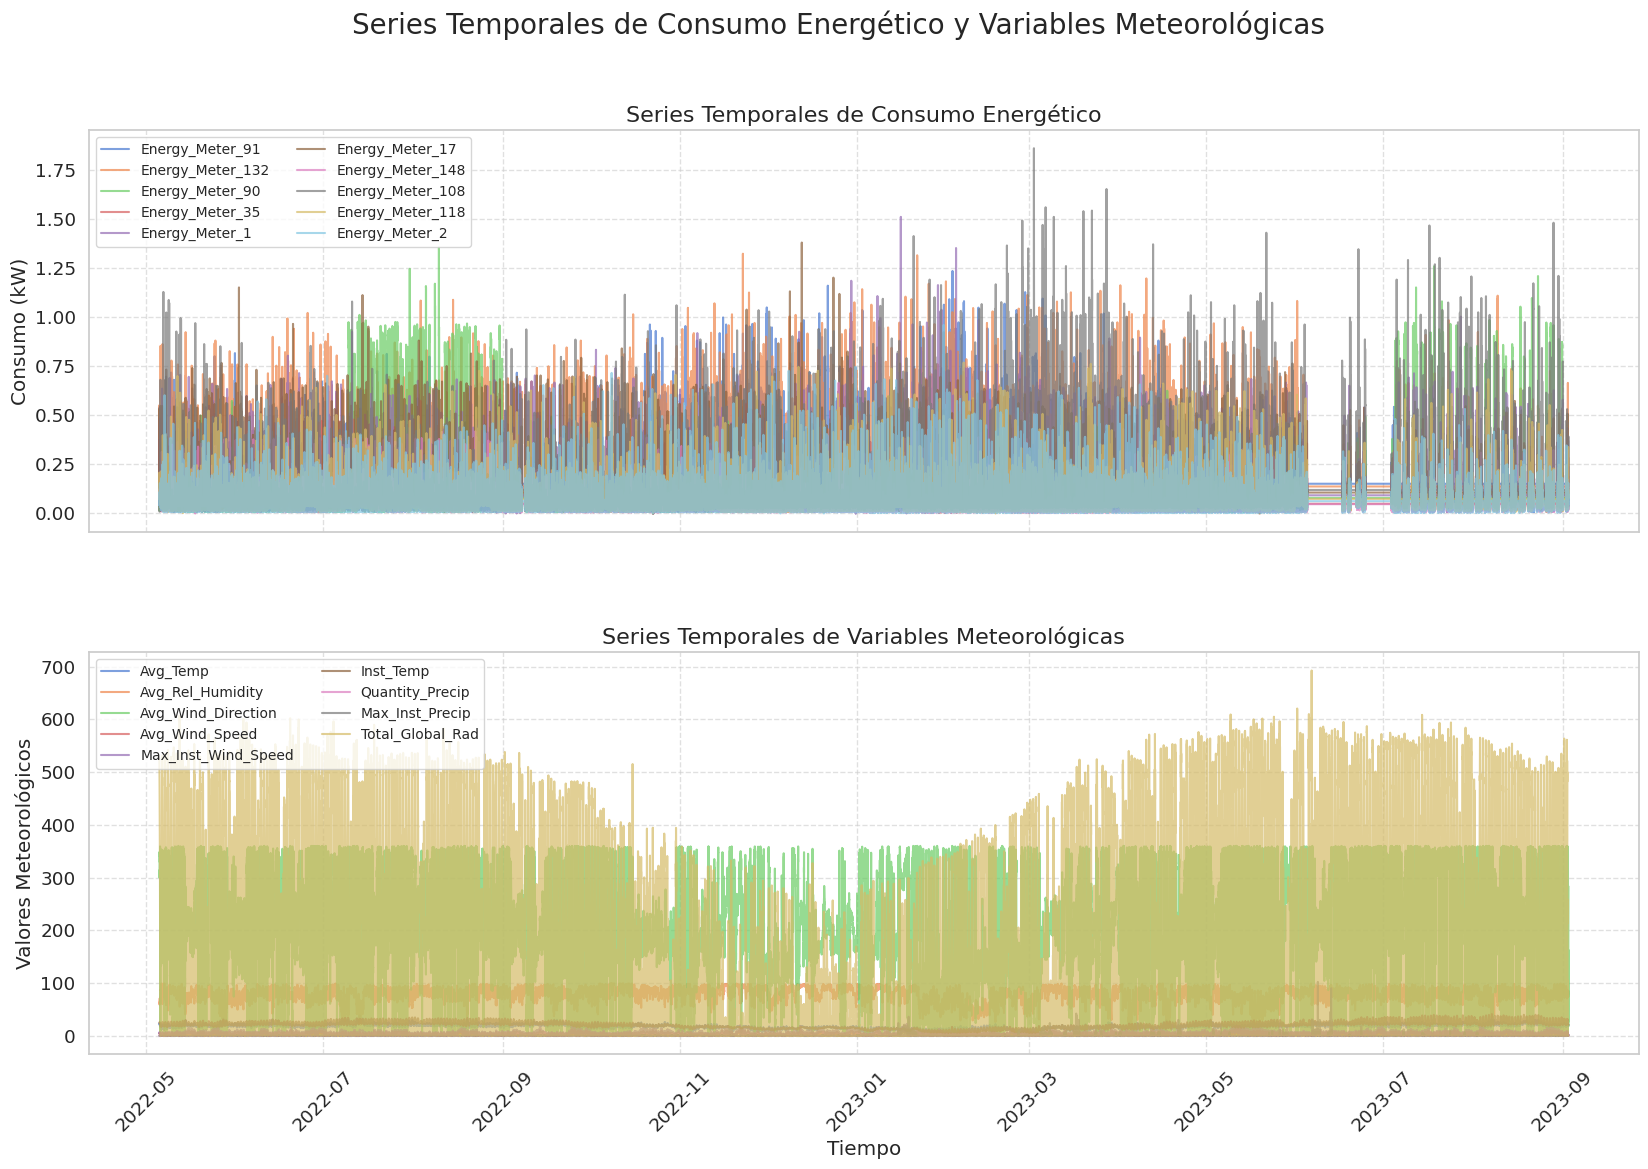

In [42]:


# Configuración de estilo para gráficos profesionales
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

# Selección de columnas para graficar
energy_columns = [col for col in data_energy_knn.columns if 'Energy_Meter' in col]
weather_columns = ['Avg_Temp', 'Avg_Rel_Humidity', 'Avg_Wind_Direction', 
                   'Avg_Wind_Speed', 'Max_Inst_Wind_Speed', 'Inst_Temp', 
                   'Quantity_Precip', 'Max_Inst_Precip', 'Total_Global_Rad']

# Configurar el tamaño del gráfico
fig, axs = plt.subplots(2, 1, figsize=(20, 12), sharex=True, gridspec_kw={'hspace': 0.3})

# Gráfico de consumo energético
for col in energy_columns:
    axs[0].plot(data_energy_knn.index, data_energy_knn[col], label=col, alpha=0.7, linewidth=1.5)
axs[0].set_title("Series Temporales de Consumo Energético", fontsize=16)
axs[0].set_ylabel("Consumo (kW)")
axs[0].legend(loc='upper left', ncol=2, fontsize=10)
axs[0].grid(True, linestyle='--', alpha=0.6)

# Gráfico de variables meteorológicas
for col in weather_columns:
    axs[1].plot(data_energy_knn.index, data_energy_knn[col], label=col, alpha=0.7, linewidth=1.5)
axs[1].set_title("Series Temporales de Variables Meteorológicas", fontsize=16)
axs[1].set_ylabel("Valores Meteorológicos")
axs[1].legend(loc='upper left', ncol=2, fontsize=10)
axs[1].grid(True, linestyle='--', alpha=0.6)

# Configuración general
fig.suptitle("Series Temporales de Consumo Energético y Variables Meteorológicas", fontsize=20)
axs[1].set_xlabel("Tiempo")
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajuste para incluir el título

# Guardar gráfico en alta calidad
plt.savefig("series_temporales_consumo.png", dpi=300, bbox_inches='tight')

# Mostrar el gráfico
plt.show()


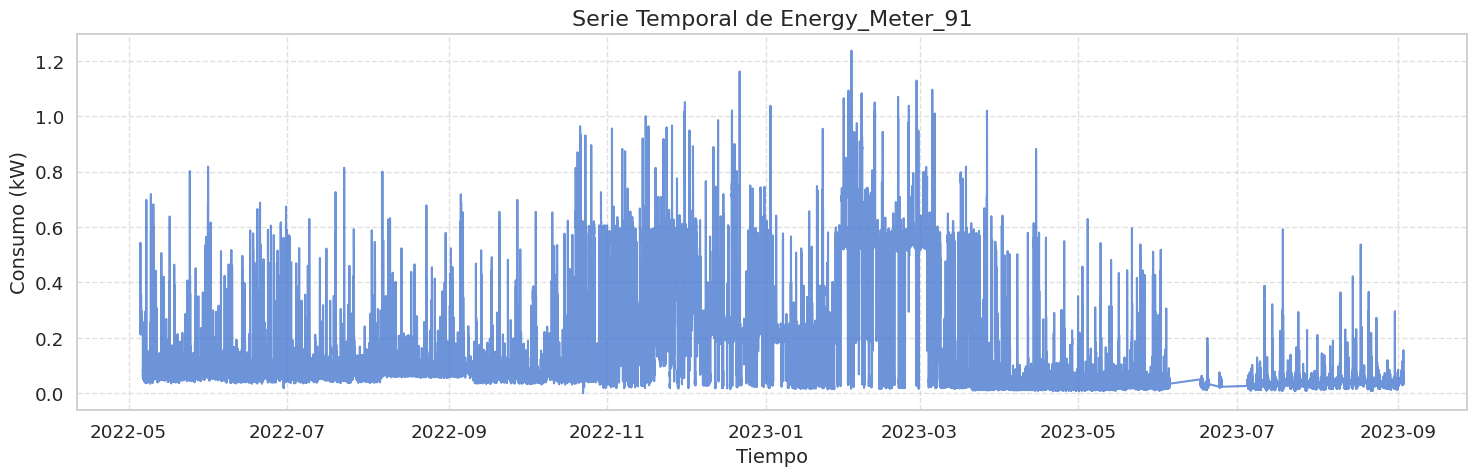

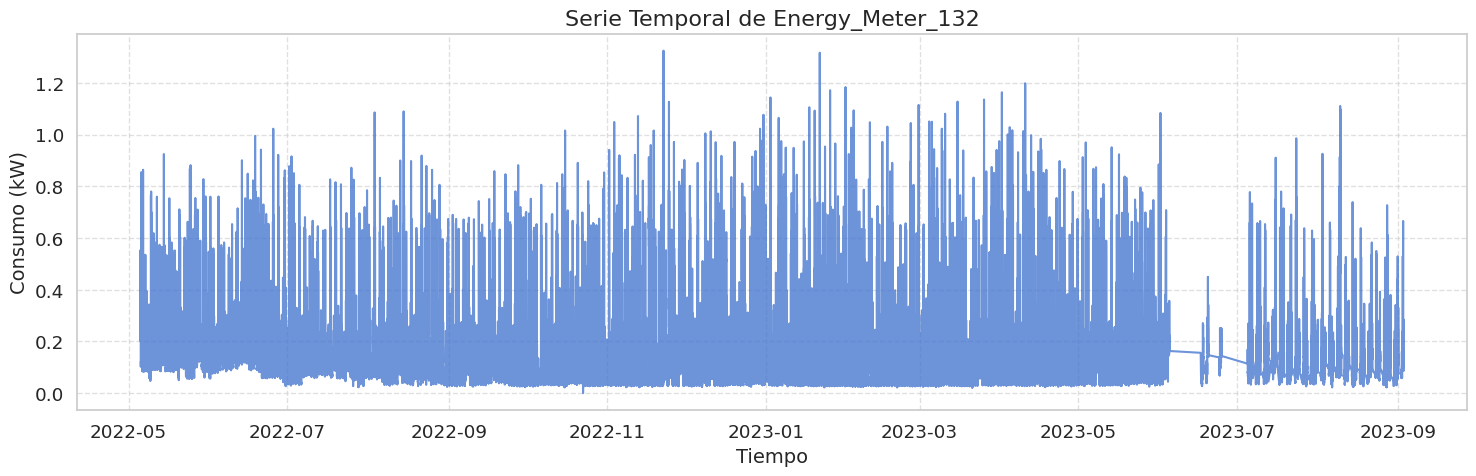

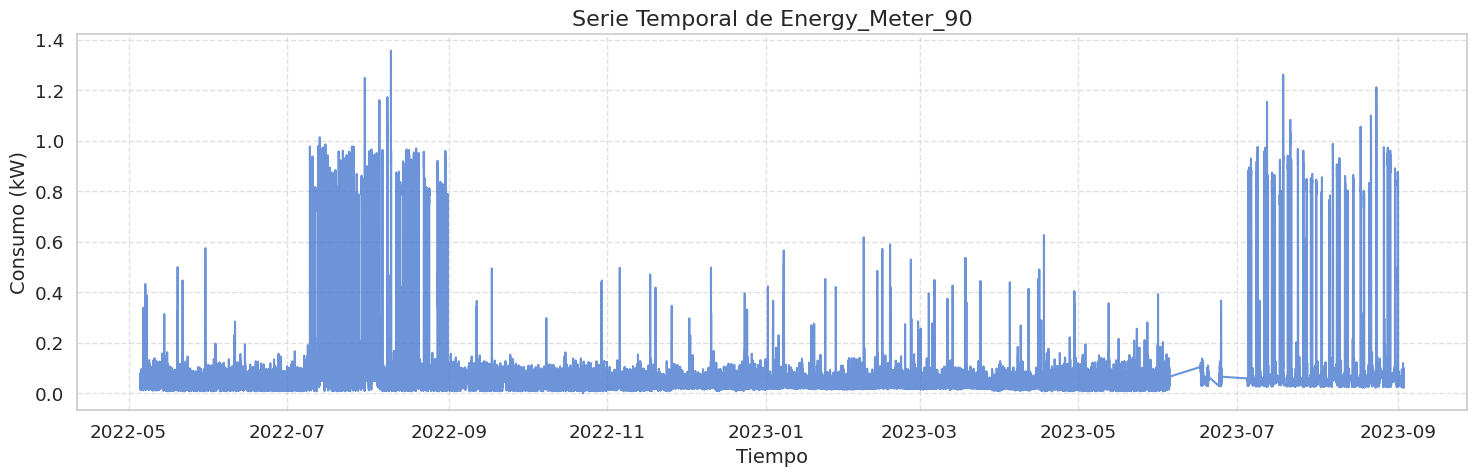

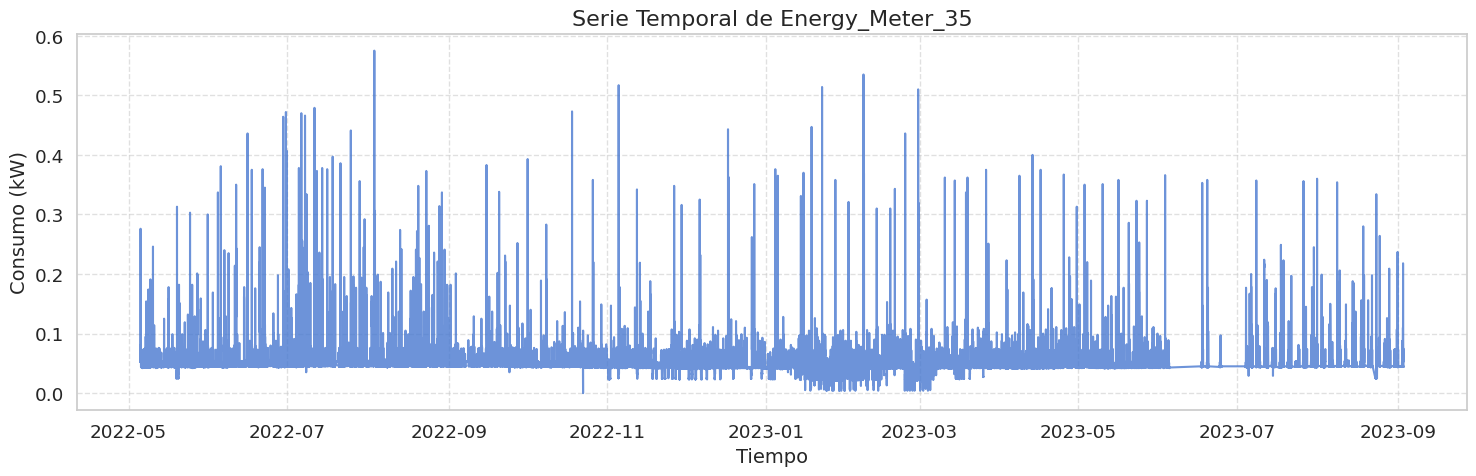

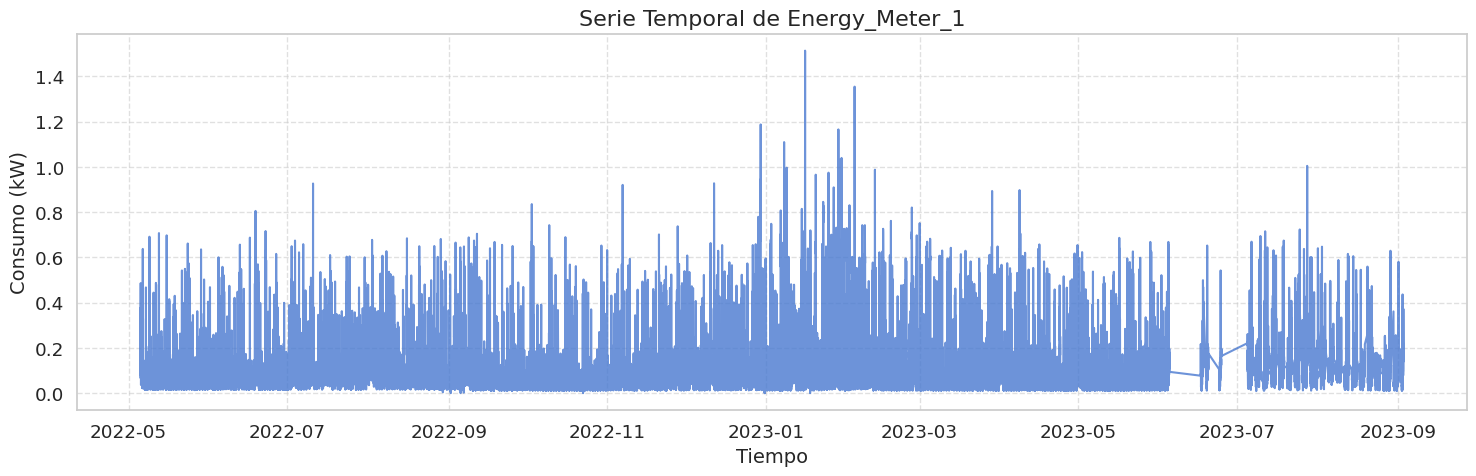

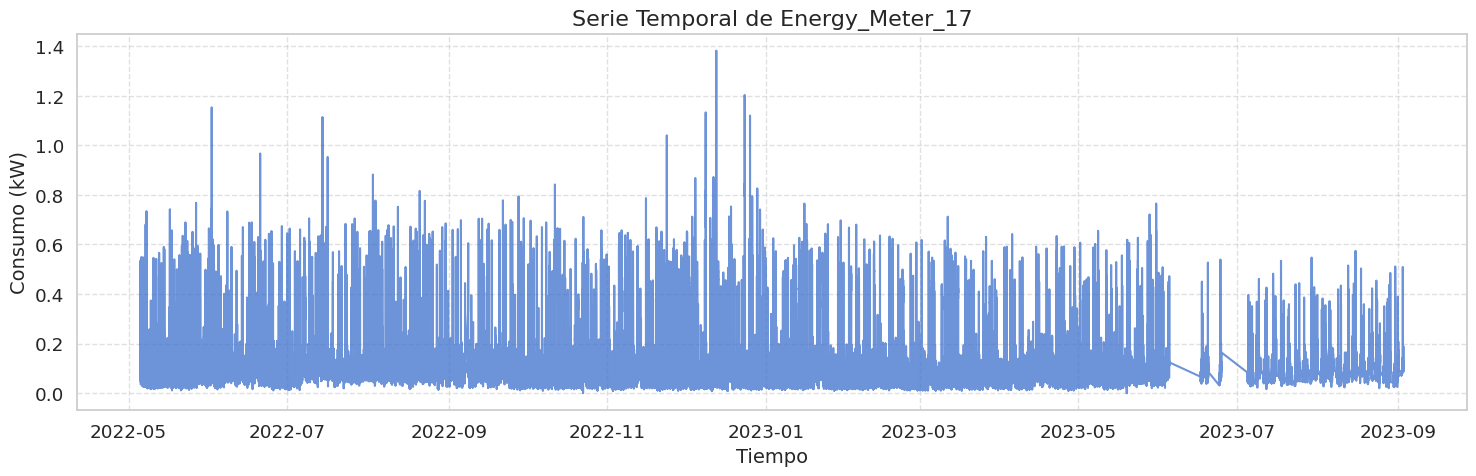

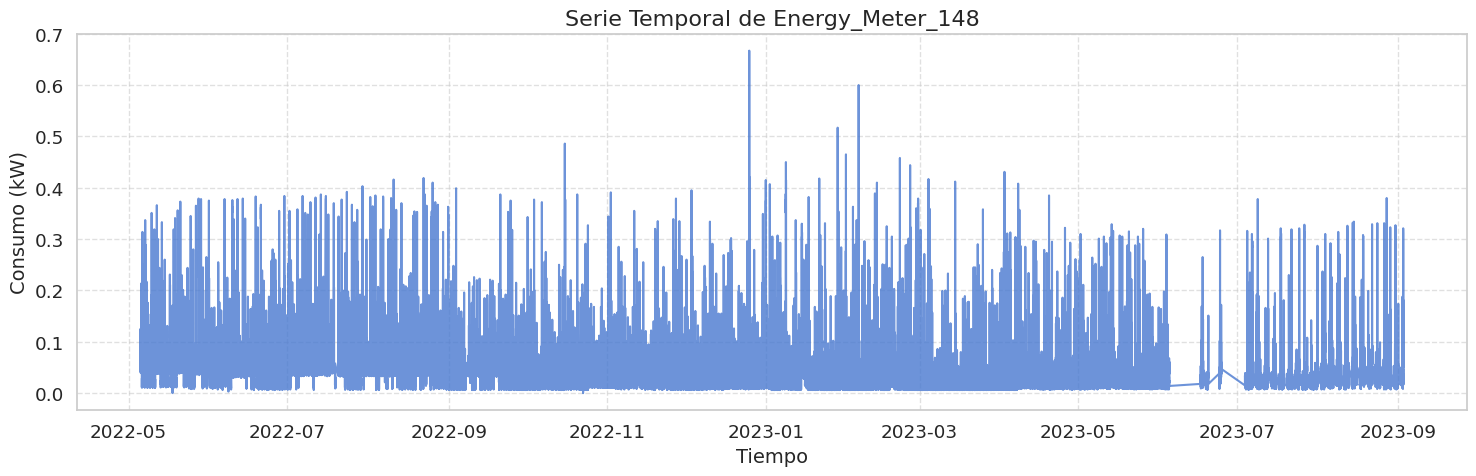

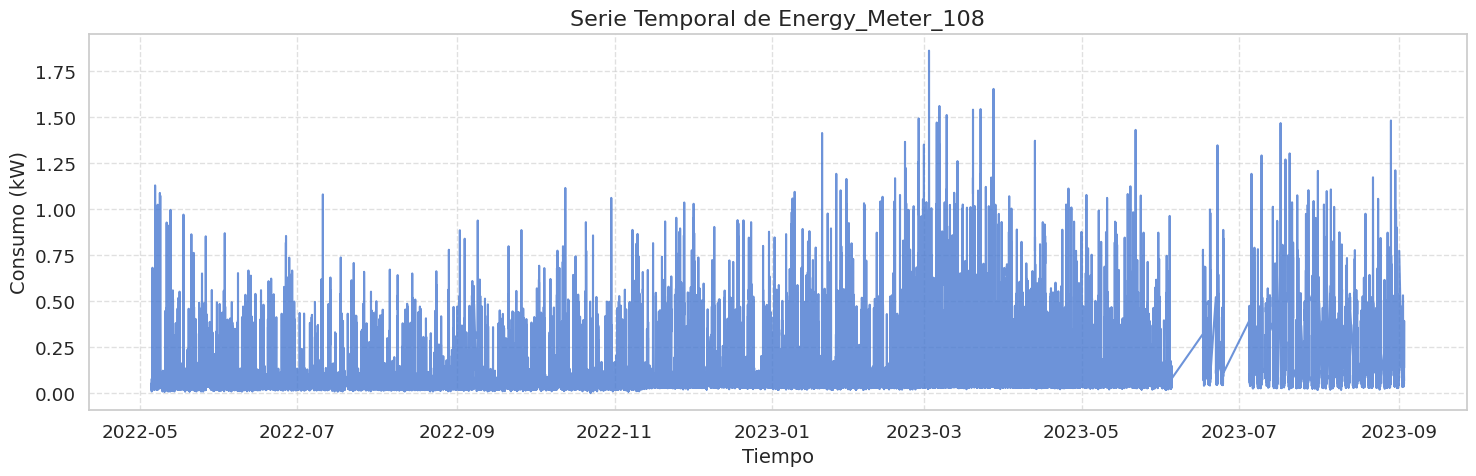

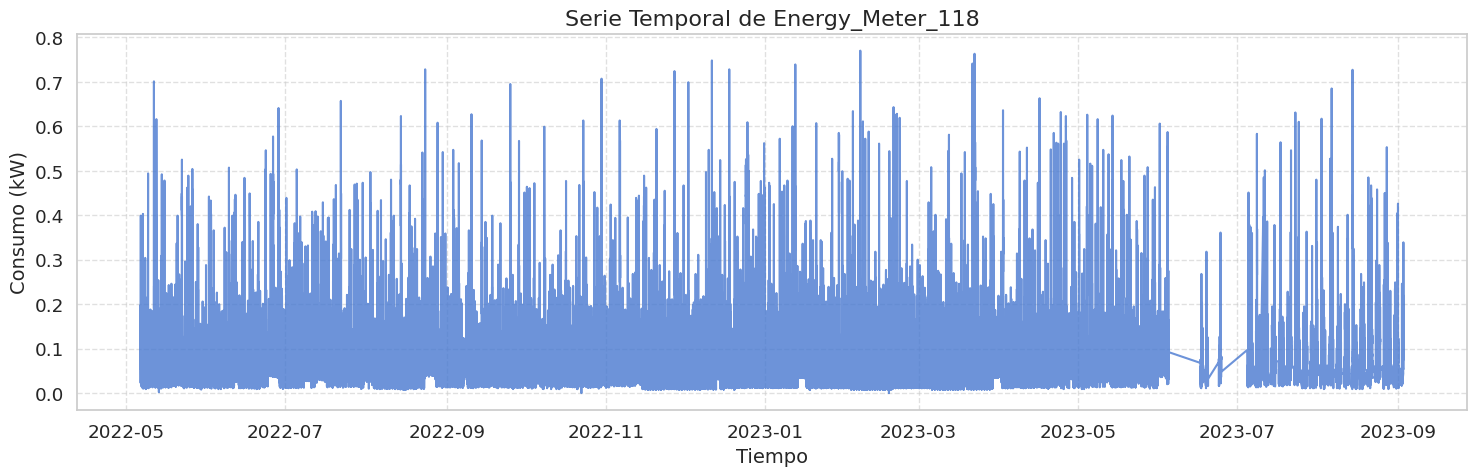

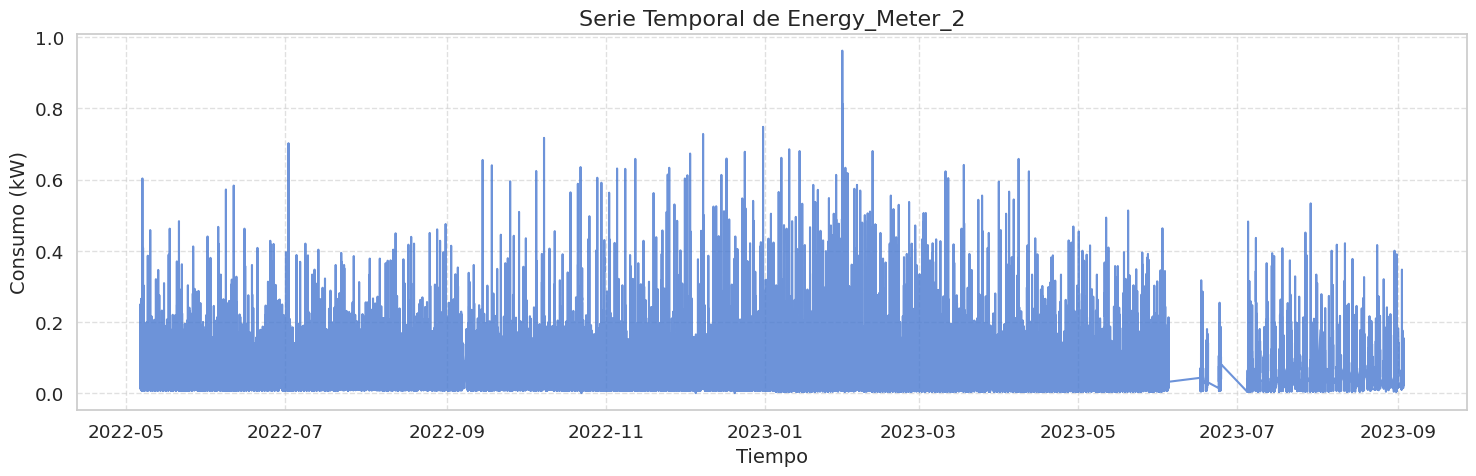

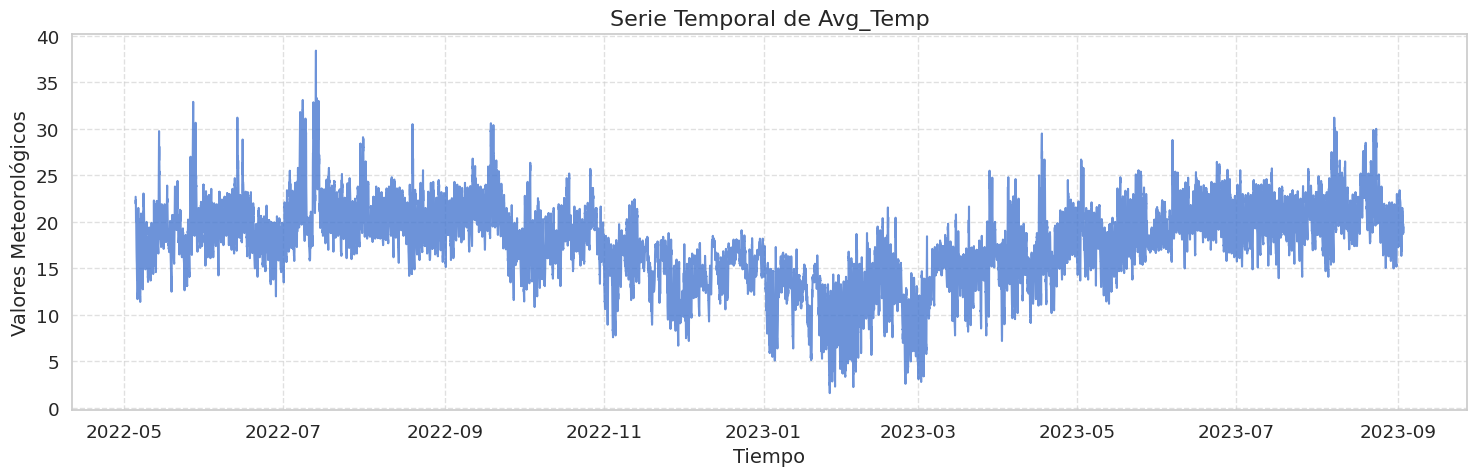

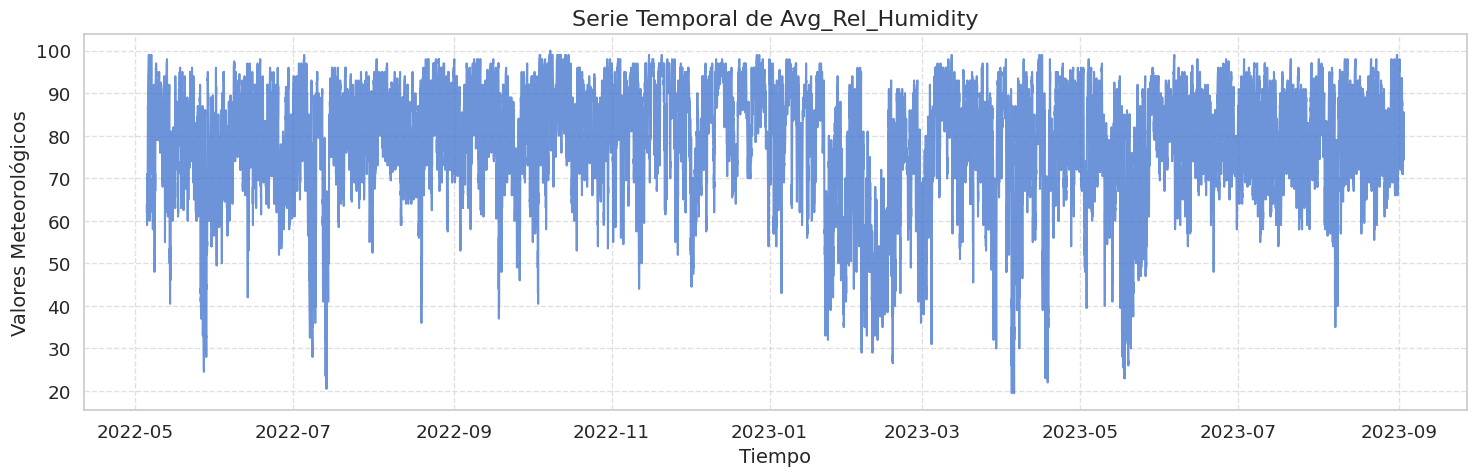

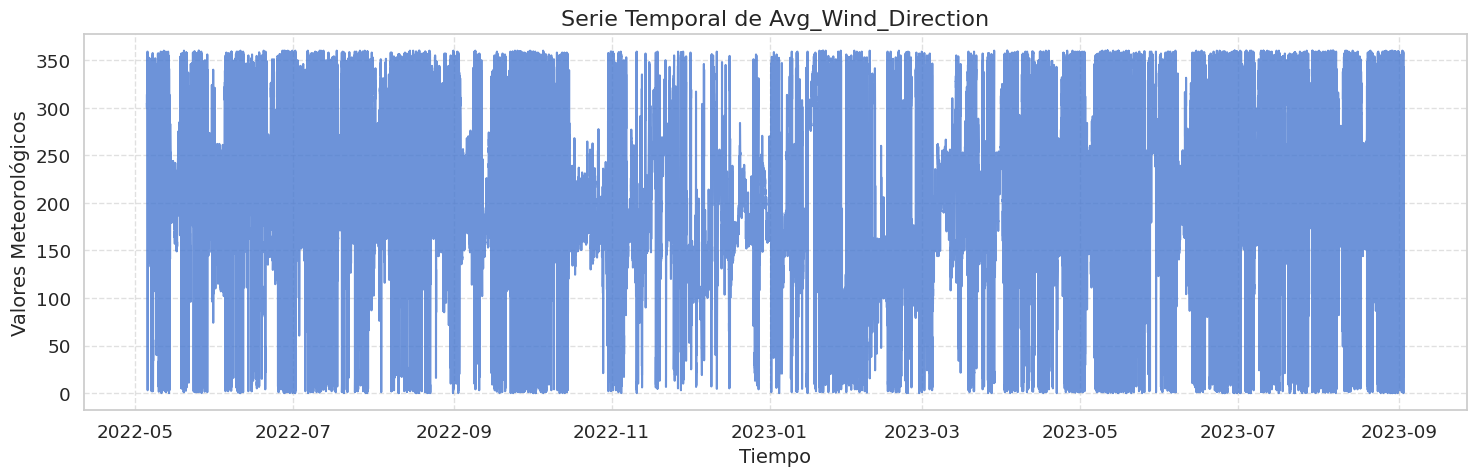

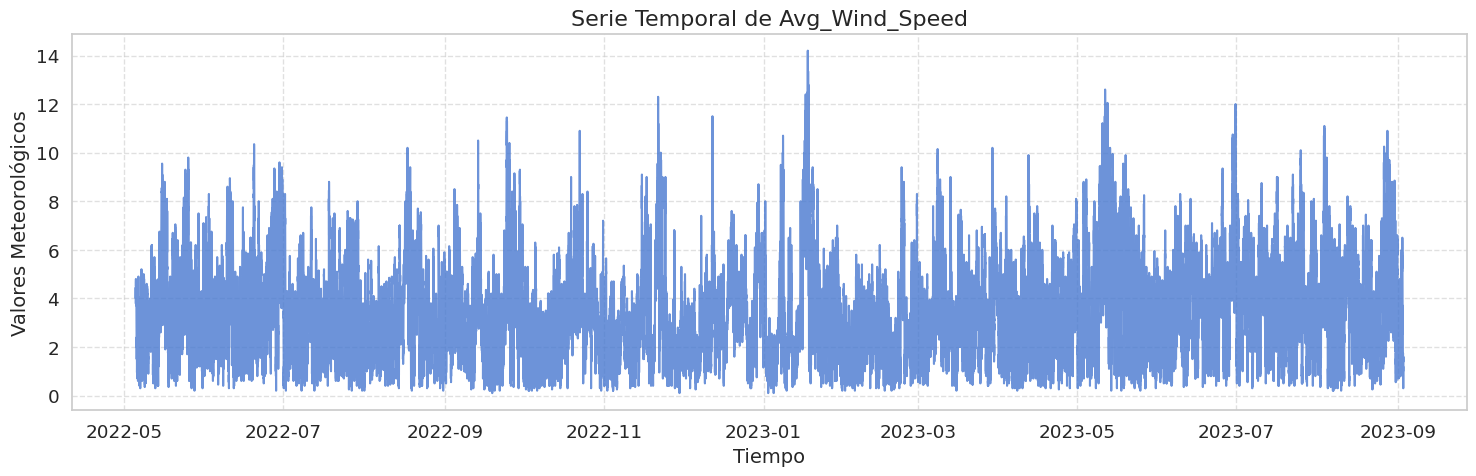

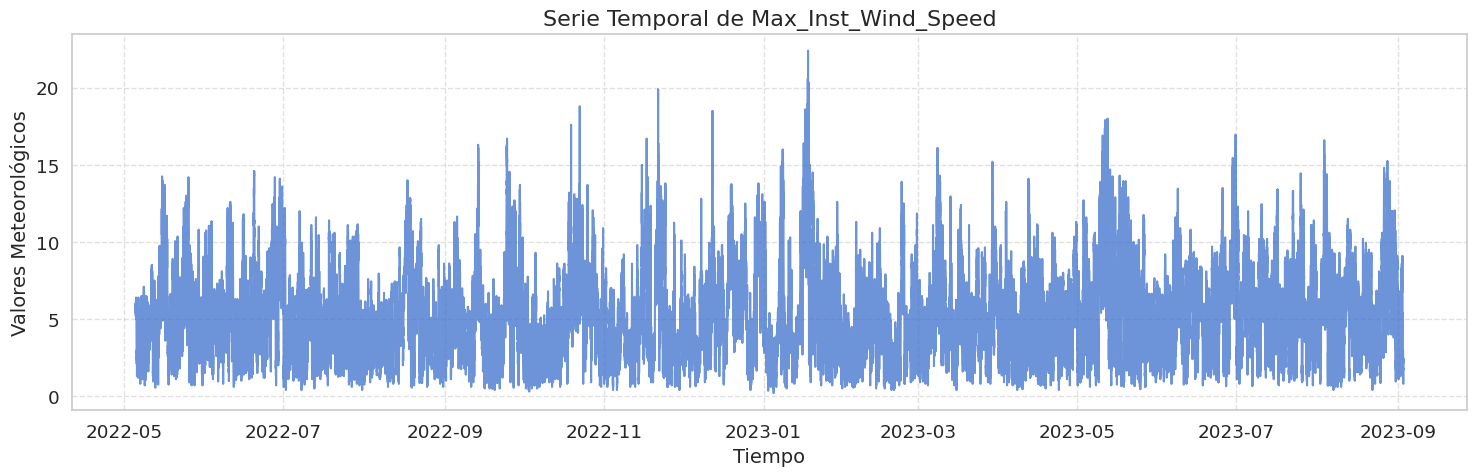

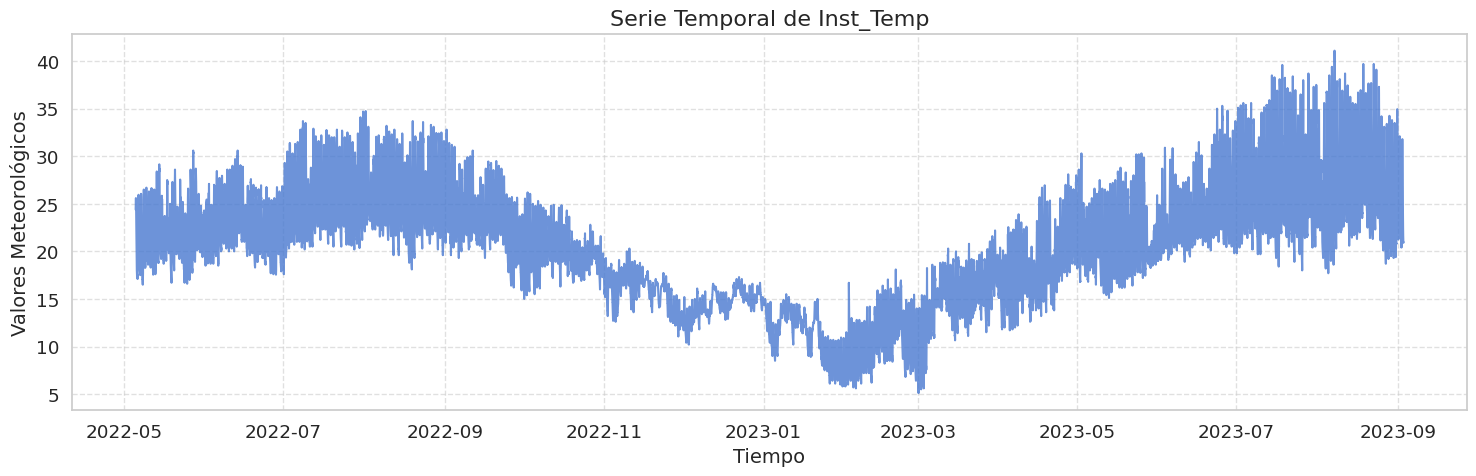

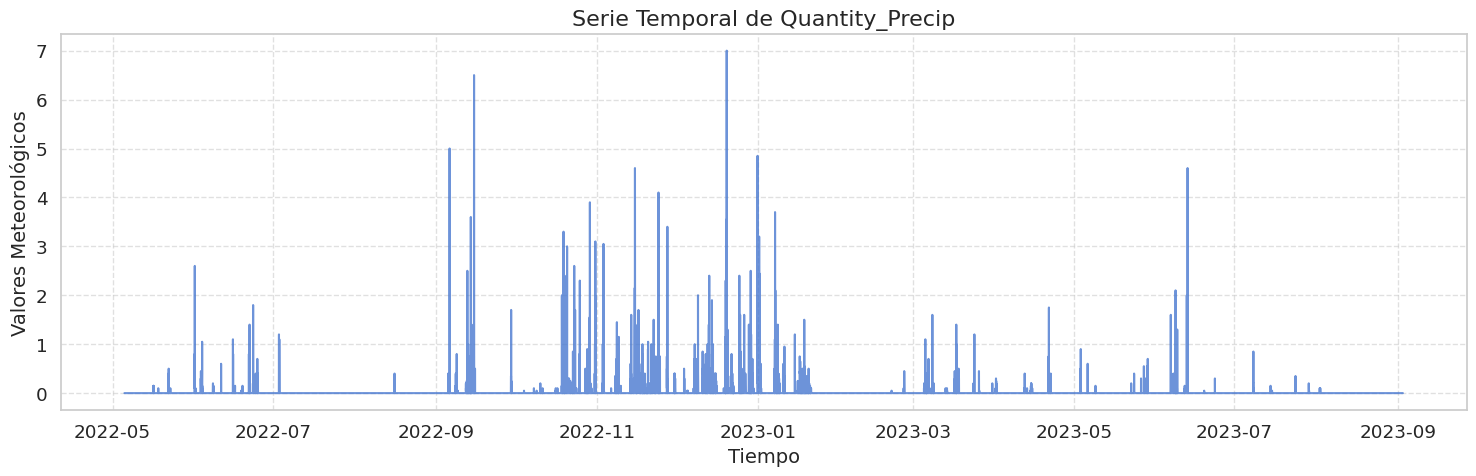

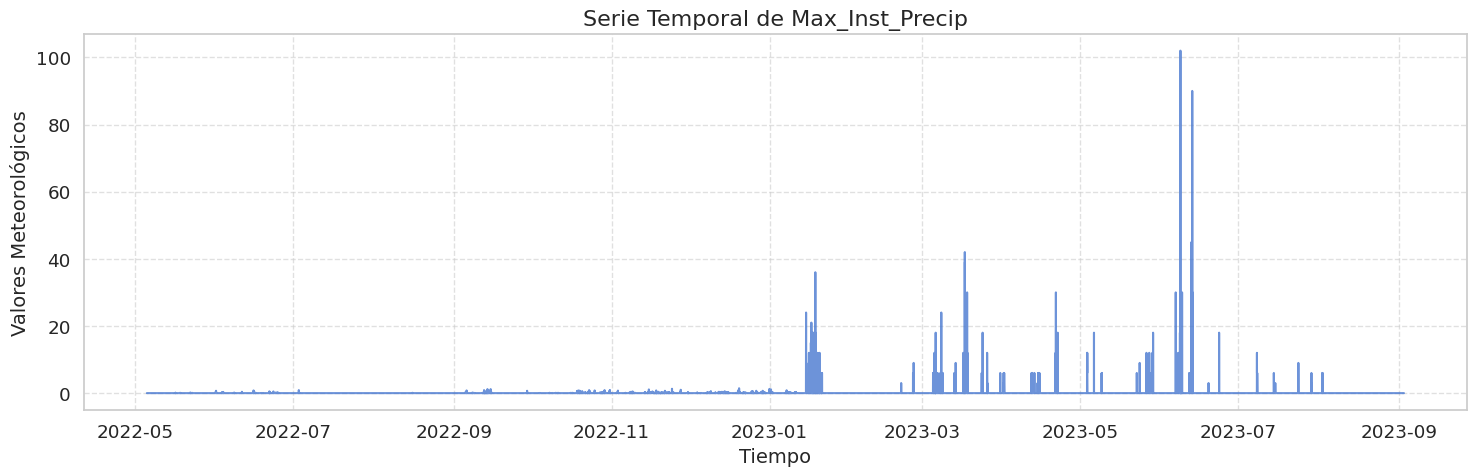

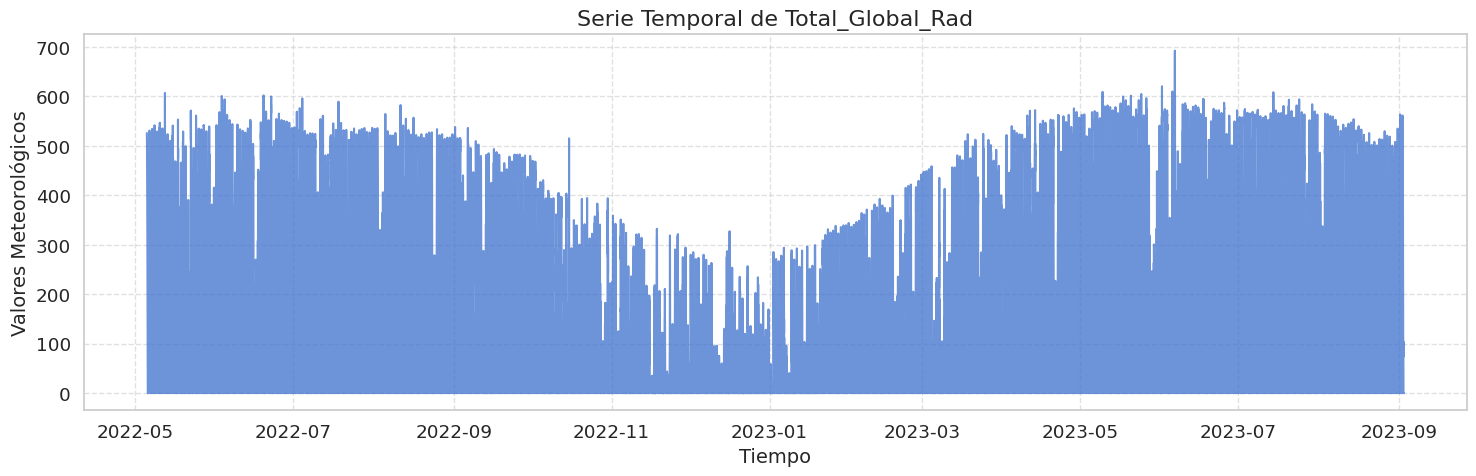

In [43]:
# Esto lo he hecho con todod los enery_meter new_dataset valores en bruto
import os
energy_columns = [col for col in new_dataset.columns if 'Energy_Meter' in col]
weather_columns = ['Avg_Temp', 'Avg_Rel_Humidity', 'Avg_Wind_Direction', 
                   'Avg_Wind_Speed', 'Max_Inst_Wind_Speed', 'Inst_Temp', 
                   'Quantity_Precip', 'Max_Inst_Precip', 'Total_Global_Rad']
# Crear carpetas para guardar los gráficos si no existen
os.makedirs("graficos/Energy_Meters", exist_ok=True)
os.makedirs("graficos/Weather_Variables", exist_ok=True)

# Gráficos para cada Energy_Meter
for col in energy_columns:
    plt.figure(figsize=(15, 5))
    sns.lineplot(data=new_dataset, x=new_dataset.index, y=col, linewidth=1.5, alpha=0.8)
    plt.title(f"Serie Temporal de {col}", fontsize=16)
    plt.xlabel("Tiempo", fontsize=14)
    plt.ylabel("Consumo (kW)", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    # Guardar el gráfico
    plt.savefig(f"graficos/Energy_Meters/{col}.png", dpi=300, bbox_inches='tight')
    plt.show()

# Gráficos para cada variable meteorológica
for col in weather_columns:
    plt.figure(figsize=(15, 5))
    sns.lineplot(data=new_dataset, x=new_dataset.index, y=col, linewidth=1.5, alpha=0.8)
    plt.title(f"Serie Temporal de {col}", fontsize=16)
    plt.xlabel("Tiempo", fontsize=14)
    plt.ylabel("Valores Meteorológicos", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    # Guardar el gráfico
    plt.savefig(f"graficos/Weather_Variables/{col}.png", dpi=300, bbox_inches='tight')
    plt.show()


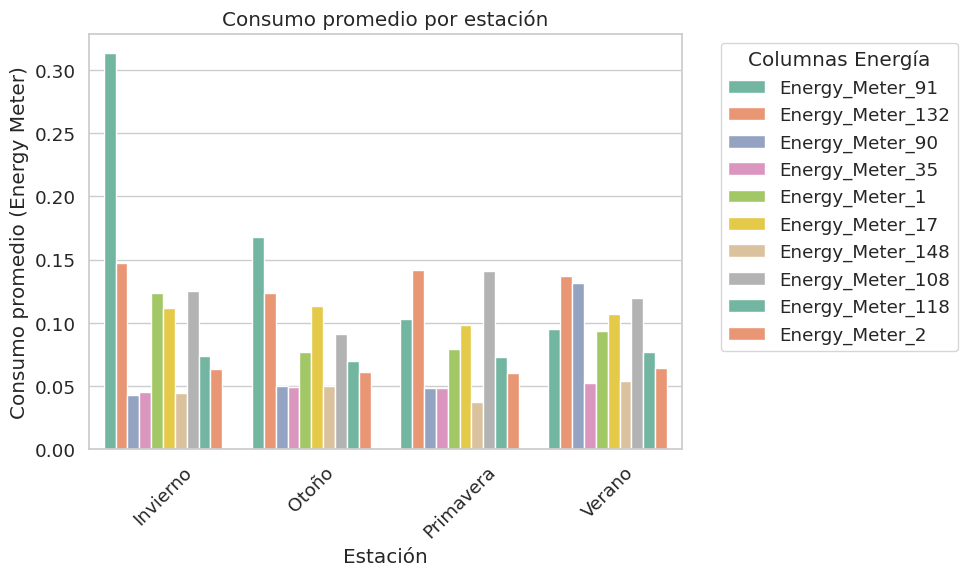

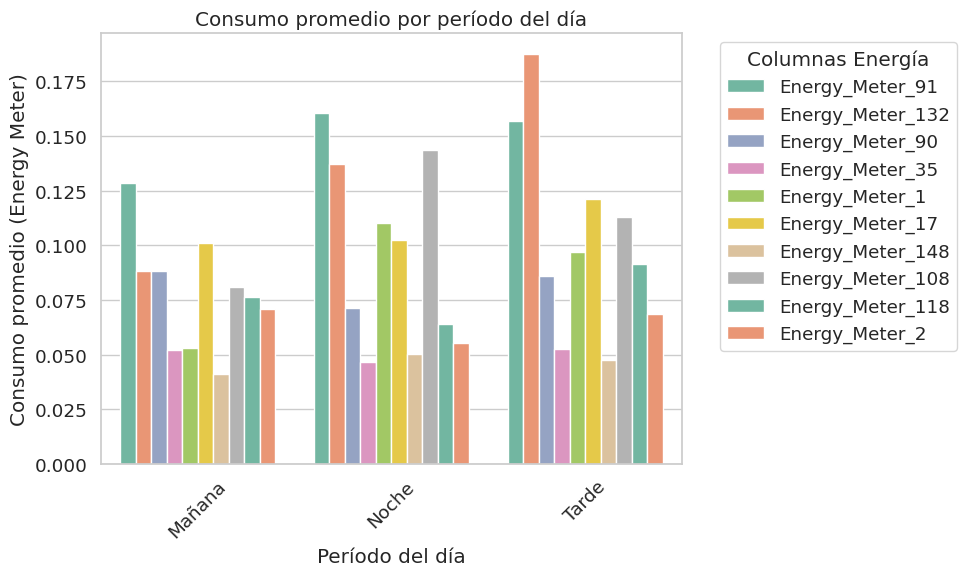

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supongamos que el índice "Time" ya está en formato datetime
#data_energy_knn.index = pd.to_datetime(data_energy_knn.index)

# 1. Crear columna de estacionalidad
def get_season(date):
    if date.month in [12, 1, 2]:
        return 'Invierno'
    elif date.month in [3, 4, 5]:
        return 'Primavera'
    elif date.month in [6, 7, 8]:
        return 'Verano'
    else:
        return 'Otoño'

data_energy_knn['Estacion'] = data_energy_knn.index.map(get_season)

# 2. Crear columna de período del día
def get_period_of_day(hour):
    if 6 <= hour < 12:
        return 'Mañana'
    elif 12 <= hour < 18:
        return 'Tarde'
    else:
        return 'Noche'

data_energy_knn['Periodo'] = data_energy_knn.index.hour.map(get_period_of_day)

# 3. Visualización: Consumo promedio por estación
plt.figure(figsize=(10, 6))
sns.barplot(
    data=data_energy_knn.groupby('Estacion')[columnas_energia].mean().reset_index().melt(id_vars='Estacion'),
    x='Estacion', y='value', hue='variable', palette='Set2'
)
plt.title('Consumo promedio por estación')
plt.ylabel('Consumo promedio (Energy Meter)')
plt.xlabel('Estación')
plt.xticks(rotation=45)
plt.legend(title='Columnas Energía', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('../Energia/img/segmento_estacion.png')
plt.show()

# 4. Visualización: Consumo promedio por período del día
plt.figure(figsize=(10, 6))
sns.barplot(
    data=data_energy_knn.groupby('Periodo')[columnas_energia].mean().reset_index().melt(id_vars='Periodo'),
    x='Periodo', y='value', hue='variable', palette='Set2'
)
plt.title('Consumo promedio por período del día')
plt.ylabel('Consumo promedio (Energy Meter)')
plt.xlabel('Período del día')
plt.xticks(rotation=45)
plt.legend(title='Columnas Energía', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('../Energia/img/segmento_mañana_noche_tarde.png')
plt.show()


Day_Type
Día Laborable    33264
Fin de Semana    13344
Name: count, dtype: int64


<Figure size 1200x600 with 0 Axes>

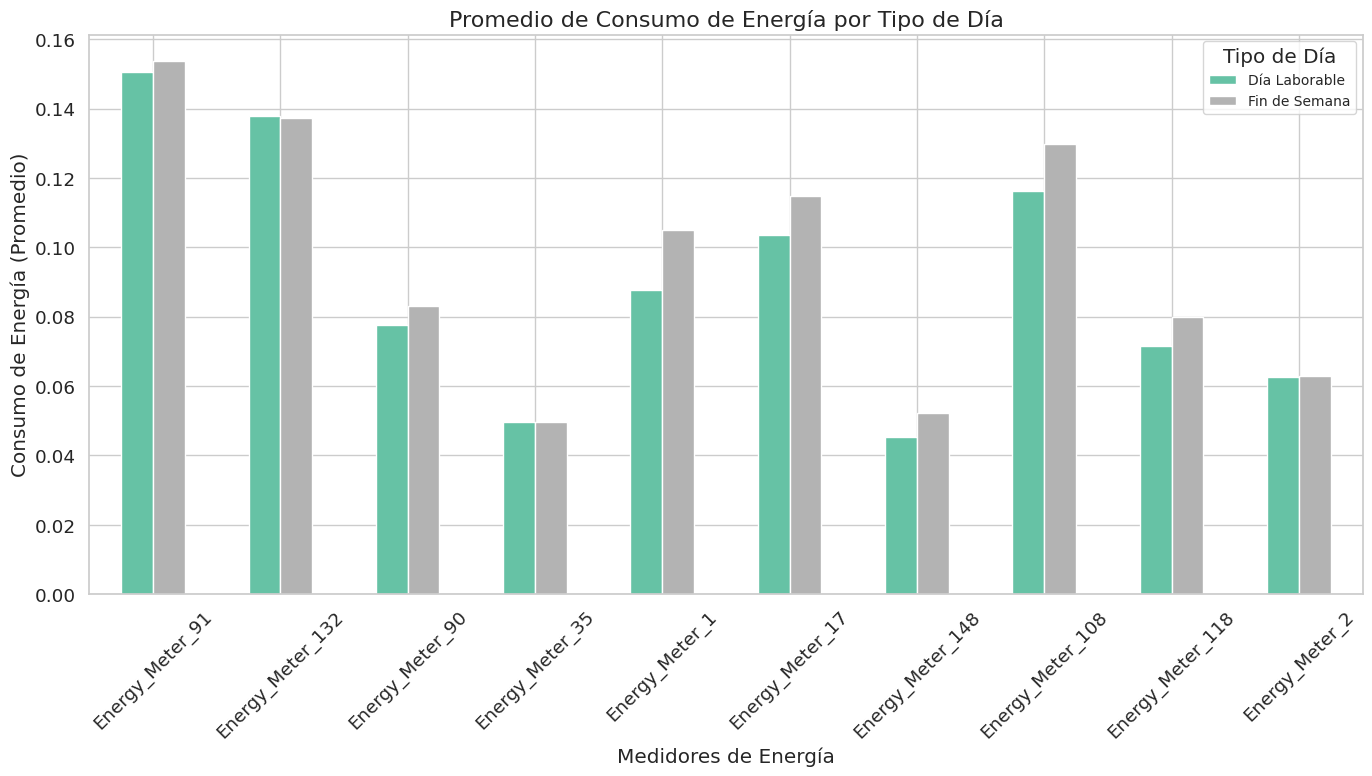

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Asumimos que data_energy_knn ya tiene un índice temporal llamado "Time"
# Crear una columna para diferenciar días laborables y fines de semana
data_energy_knn['Day_Type'] = data_energy_knn.index.to_series().dt.weekday.map(
    lambda x: 'Fin de Semana' if x >= 5 else 'Día Laborable'
)

# Verificar la segmentación
print(data_energy_knn['Day_Type'].value_counts())

# Agrupar por tipo de día y calcular el promedio de las columnas de energía
mean_energy_by_day = data_energy_knn.groupby('Day_Type')[columnas_energia].mean()

# Crear el gráfico
plt.figure(figsize=(12, 6))
mean_energy_by_day.T.plot(kind='bar', figsize=(14, 8), colormap='Set2')

# Configuración del gráfico
plt.title("Promedio de Consumo de Energía por Tipo de Día", fontsize=16)
plt.ylabel("Consumo de Energía (Promedio)")
plt.xlabel("Medidores de Energía")
plt.legend(title="Tipo de Día", fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()

# Guardar la imagen
plt.savefig('../Energia/img/segmento_dias_laborables_vs_fines_de_semana.png')

plt.show()


Temp_Category
Media    42686
Baja      2653
Alta      1269
Name: count, dtype: int64


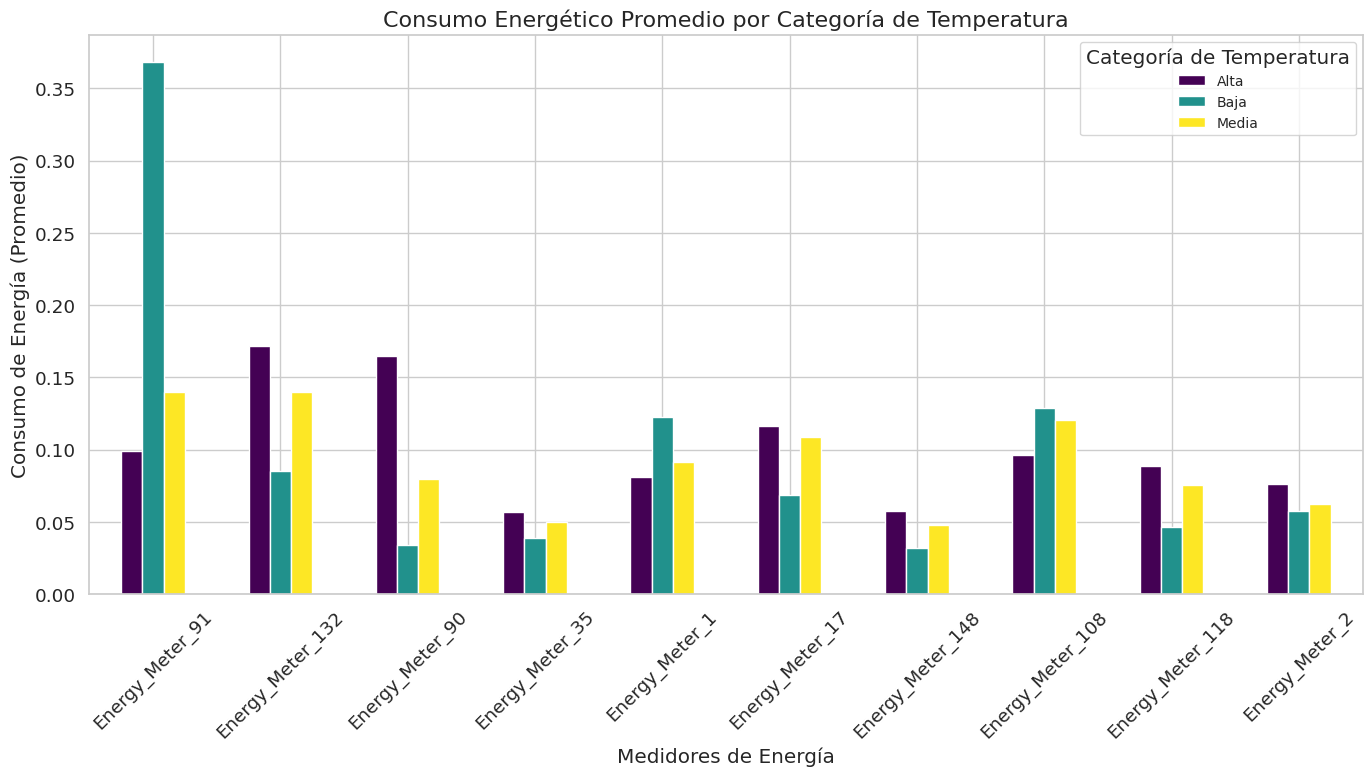

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

dataset_categorizado=data_energy_knn.copy() 
# Crear categorías de temperatura: baja, media, alta
def categorize_temperature(temp):
    if temp < 10:  # Umbral para temperatura baja
        return 'Baja'
    elif 10 <= temp <= 25:  # Umbral para temperatura media
        return 'Media'
    else:  # Temperatura alta
        return 'Alta'

# Crear una nueva columna categorizando la temperatura
dataset_categorizado['Temp_Category'] = dataset_categorizado['Avg_Temp'].apply(categorize_temperature)

# Verificar la segmentación
print(dataset_categorizado['Temp_Category'].value_counts())

# Agrupar por categoría de temperatura y calcular el promedio de las columnas de energía
mean_energy_by_temp = dataset_categorizado.groupby('Temp_Category')[columnas_energia].mean()

# Crear un gráfico de barras apiladas para visualizar el consumo energético
mean_energy_by_temp.T.plot(kind='bar', figsize=(14, 8), colormap='viridis')

# Configuración del gráfico
plt.title("Consumo Energético Promedio por Categoría de Temperatura", fontsize=16)
plt.ylabel("Consumo de Energía (Promedio)")
plt.xlabel("Medidores de Energía")
plt.xticks(rotation=45)
plt.legend(title="Categoría de Temperatura", fontsize=10)
plt.tight_layout()

# Guardar la imagen
plt.savefig('../Energia/img/segmento_consumo_por_condiciones_meteorologicas.png')

plt.show()


Correlación entre 'Energy_Meter_91' y 'Avg_Temp': -0.3888614937106018


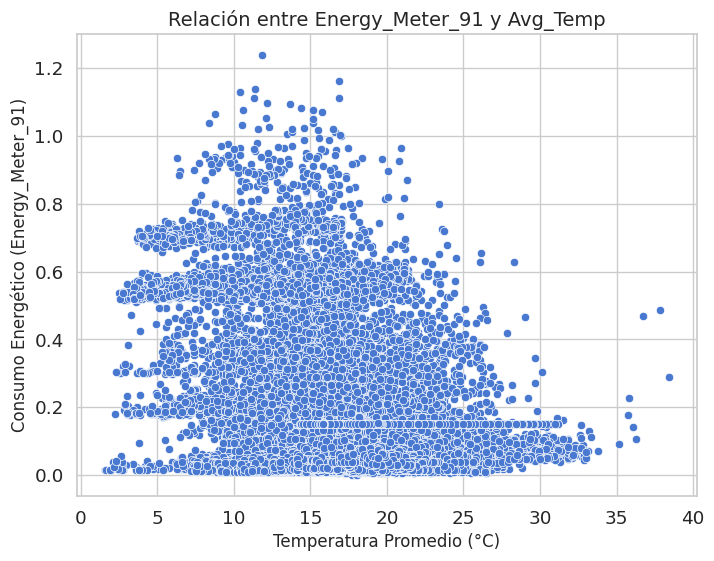


Distribución de las observaciones en segmentos de temperatura:
Temp_Segment
Media    31312
Alta     12570
Baja      2726
Name: count, dtype: int64


/tmp/ipykernel_214890/1765582198.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data_energy_knn['Temp_Segment'], y=data_energy_knn['Energy_Meter_91'], palette="Set2")


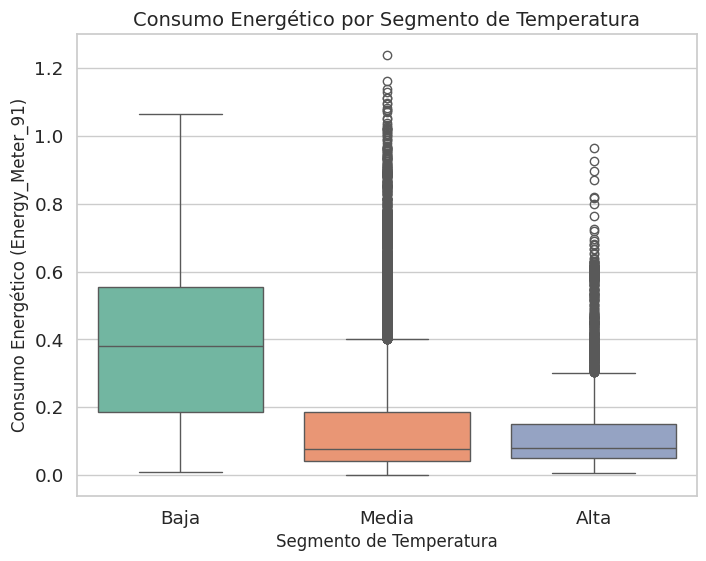

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Suponiendo que ya tienes el DataFrame 'data_energy_knn' cargado y limpio

# Calcular la correlación entre 'Energy_Meter_91' y 'Avg_Temp'
correlation = data_energy_knn['Energy_Meter_91'].corr(data_energy_knn['Avg_Temp'])
print(f"Correlación entre 'Energy_Meter_91' y 'Avg_Temp': {correlation}")

# Visualizar la relación con un gráfico de dispersión
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_energy_knn['Avg_Temp'], y=data_energy_knn['Energy_Meter_91'], color='b')
plt.title("Relación entre Energy_Meter_91 y Avg_Temp", fontsize=14)
plt.xlabel("Temperatura Promedio (°C)", fontsize=12)
plt.ylabel("Consumo Energético (Energy_Meter_91)", fontsize=12)
plt.savefig('../Energia/img/segmento_relacion_energy_meter91vsavg_temp.png')
plt.show()

# Crear segmentos de los datos en función de la temperatura y el consumo energético
# Puedes segmentar la temperatura en categorías como baja, media y alta
bins_temp = [-float('inf'), 10, 20, float('inf')]  # Definir límites de temperatura
labels_temp = ['Baja', 'Media', 'Alta']  # Etiquetas de segmentos
data_energy_knn['Temp_Segment'] = pd.cut(data_energy_knn['Avg_Temp'], bins=bins_temp, labels=labels_temp)

# Ver el número de observaciones en cada segmento de temperatura
print("\nDistribución de las observaciones en segmentos de temperatura:")
print(data_energy_knn['Temp_Segment'].value_counts())

# Visualizar la segmentación con un boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=data_energy_knn['Temp_Segment'], y=data_energy_knn['Energy_Meter_91'], palette="Set2")
plt.title("Consumo Energético por Segmento de Temperatura", fontsize=14)
plt.xlabel("Segmento de Temperatura", fontsize=12)
plt.ylabel("Consumo Energético (Energy_Meter_91)", fontsize=12)
plt.savefig('../Energia/img/segmento_relacion_energy_meter91vsavg_tempboxplot.png')
plt.show()


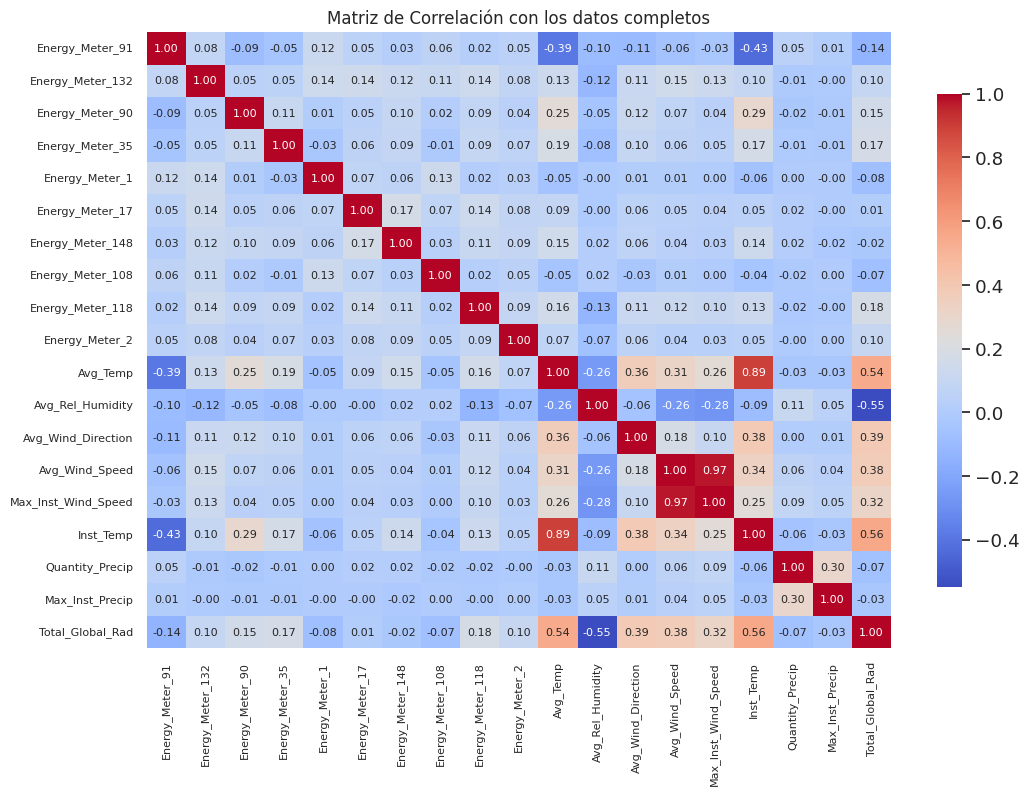

In [51]:
# Buscar correlación entre energy_columns y weather_columns
# Seleccionar columnas de medición de energía y meteorológicas
energy_columns = ['Energy_Meter_91', 'Energy_Meter_132', 'Energy_Meter_90', 'Energy_Meter_35', 
                  'Energy_Meter_1', 'Energy_Meter_17', 'Energy_Meter_148', 'Energy_Meter_108', 
                  'Energy_Meter_118', 'Energy_Meter_2']

weather_columns = ['Avg_Temp', 'Avg_Rel_Humidity', 'Avg_Wind_Direction', 'Avg_Wind_Speed', 
                   'Max_Inst_Wind_Speed', 'Inst_Temp', 'Quantity_Precip', 'Max_Inst_Precip', 'Total_Global_Rad']

# Calcular la correlación entre las columnas de energía y meteorológicas
correlation_matrix = data_energy_knn[energy_columns + weather_columns].corr()

# Crear el heatmap con rotulado más pequeño
plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,                        # Mostrar los valores en el mapa
    fmt=".2f",                         # Formato de los números (dos decimales)
    cmap="coolwarm",                   # Colormap
    annot_kws={"size": 8},             # Tamaño de fuente de las anotaciones
    cbar_kws={"shrink": 0.8}           # Ajustar el tamaño de la barra de color
)

# Ajustar el tamaño del rotulado de los ejes
plt.xticks(fontsize=8, rotation=90)    # Rotar etiquetas del eje x
plt.yticks(fontsize=8)                 # Tamaño de etiquetas del eje y
plt.title('Matriz de Correlación con los datos completos', fontsize=12)  # Título con tamaño ajustado
plt.savefig("../Energia/img/matrizcorrelacionfinal.png", dpi=100, bbox_inches='tight')
plt.show()

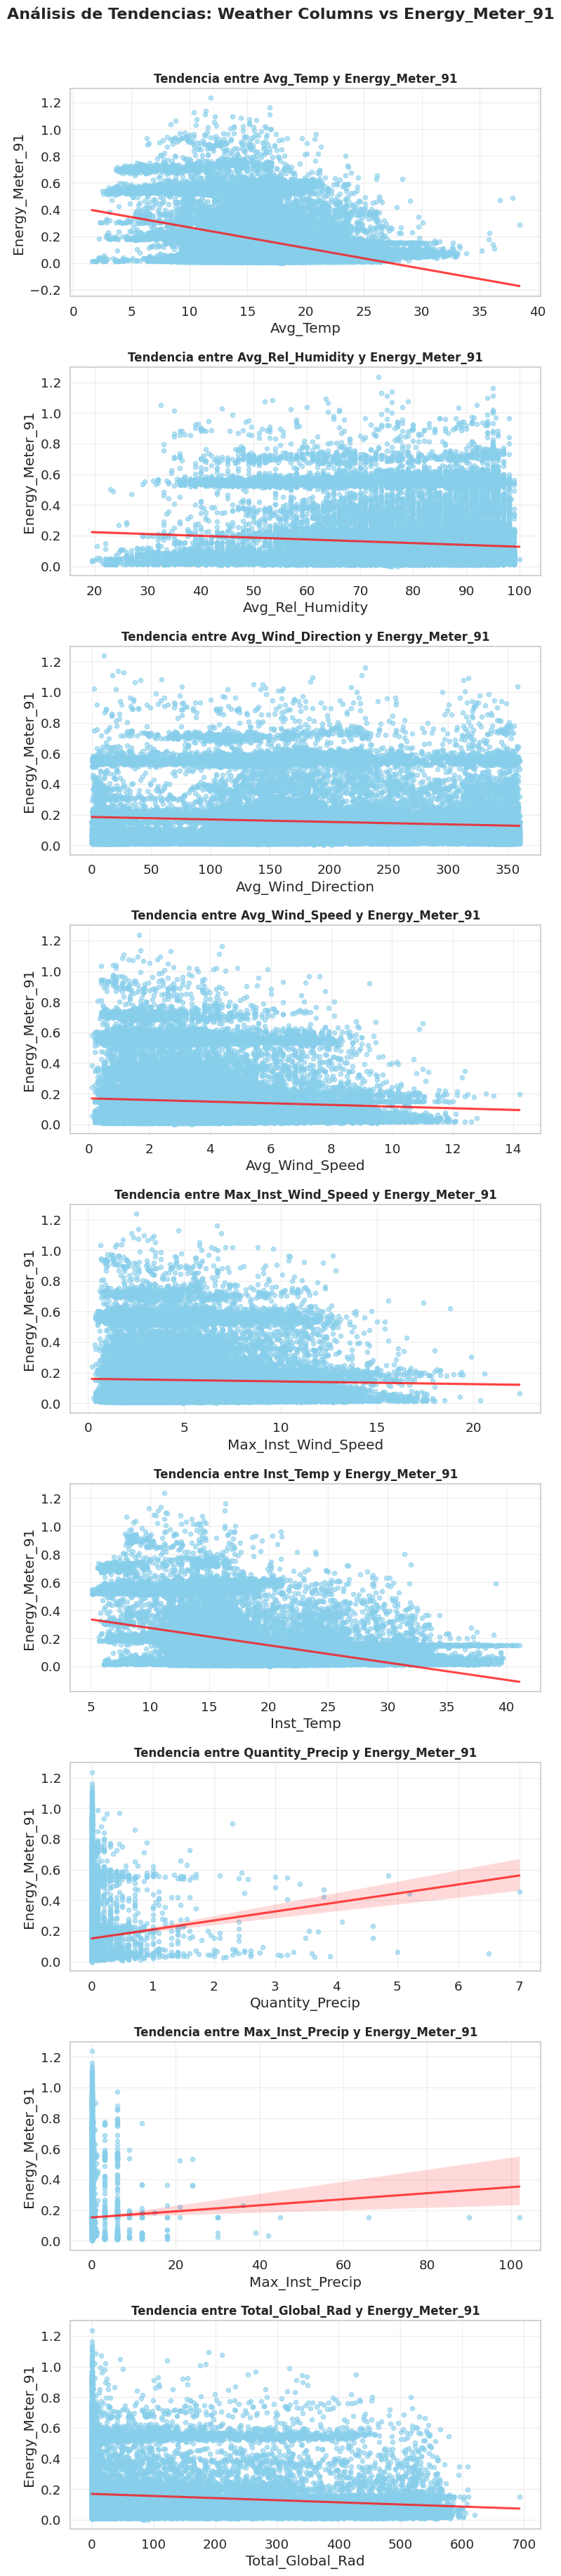

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Columnas meteorológicas y columna de energía a analizar
weather_columns = ['Avg_Temp', 'Avg_Rel_Humidity', 'Avg_Wind_Direction', 'Avg_Wind_Speed', 
                   'Max_Inst_Wind_Speed', 'Inst_Temp', 'Quantity_Precip', 'Max_Inst_Precip', 'Total_Global_Rad']
energy_column = 'Energy_Meter_91'

# Crear subplots para las relaciones entre variables meteorológicas y la columna de energía
fig, axes = plt.subplots(len(weather_columns), 1, figsize=(8, 4 * len(weather_columns)), sharex=False)

# Iterar por cada columna meteorológica para generar gráficos
for i, weather_column in enumerate(weather_columns):
    ax = axes[i]
    sns.regplot(
        data=data_energy_knn, 
        x=weather_column, 
        y=energy_column, 
        ax=ax, 
        scatter_kws={'alpha': 0.6, 's': 20},  # Configuración de puntos
        line_kws={'color': 'red', 'alpha': 0.7},  # Configuración de la línea de regresión
        color='skyblue'  # Color de los puntos
    )
    ax.set_title(f'Tendencia entre {weather_column} y {energy_column}', fontsize=12, fontweight='bold')
    ax.set_xlabel(weather_column)
    ax.set_ylabel(energy_column)
    ax.grid(alpha=0.3)

# Ajustar diseño general
plt.tight_layout()
plt.suptitle('Análisis de Tendencias: Weather Columns vs Energy_Meter_91', fontsize=16, fontweight='bold', y=1.02)

# Guardar el gráfico
output_path = "../Energia/img/analisis_tendencias.png"
plt.savefig(output_path, dpi=150, bbox_inches='tight', transparent=True)

# Mostrar gráfico
plt.show()
